# Scalable Data Mining [CS60021] - Assignment 2


**Name : `RADHIKA PATWARI`** 

**Roll-No : `18CS10062`** 

**Date : `19/09/2021`**

In [1]:
%pip install wandb -q

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 133 kB 43.1 MB/s 
     |████████████████████████████████| 97 kB 5.9 MB/s 
     |████████████████████████████████| 180 kB 43.8 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 


In [2]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
!nvidia-smi
#https://stackoverflow.com/questions/59152295/google-colab-consumes-too-much-of-internet-data

Sat Sep 18 12:03:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    58W / 149W |    775MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
## Importing required libraries
import torch
import numpy
import random
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import os, argparse

import sklearn
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [32]:
## Experimentation Parameters
use_sgd = True                            # Using sgd optimizer, else use adam optimizer
full_finetune = True                      # Train all layers, else freeze all layers and finetune only last layer
learning_rate = 0.001                     # learning rate

In [58]:
## Device Setup for Cuda 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device_{device}")

## Setting model parameters
momentum = 0.9                            # sgd momentum
test_batch_size = 100                     # test batch size
train_batch_size = 128                    # train batch size
num_epochs = 50                           # no. of epochs

## Setup wandb
wandb.init(project='sdm-asgn-2', entity='radhika_patwari')          # my project
wandb.watch_called = False                # Re-run the model without restarting the runtime, unnecessary after our next release
config = wandb.config                     # initialise wandb configuration

## Data Transformation
print('Data transformation')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

## Train & Test datasets and dataloaders for CIFAR dataset
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=train_batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=test_batch_size, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Setting wandb parameters
config.full_finetune = full_finetune
config.use_sgd = use_sgd
config.learning_rate = learning_rate
config.momentum = momentum
config.log_interval = 100                    # No. of batches to wait before logging training status
config.seed = 123                           # random seed

## Model net = Invoke pretrained ResNet18 model
print('Loading ResNet Model....')
net = models.resnet18(pretrained=True)
net.fc = nn.Linear(512, 10)

net = net.to(device)
print(f"device_{device}")

## 4 Methods experimentation
if full_finetune:                         # Train all layers
    parameters = net.parameters()
else:                                     # Freeze all layers, finetune only last layer
    for param in net.parameters():
        param.requires_grad = False
    for param in net.fc.parameters():
        param.requires_grad = True
    parameters = net.fc.parameters()

if use_sgd:                               # Use Stocashtic Gradient Descent optimizer
    optimizer = optim.SGD(parameters, lr=learning_rate, momentum=momentum)  
else:                                     # Use Adam Optimizer
    optimizer = optim.Adam(parameters, lr=learning_rate)


## Training CIFAR data
def train(epoch, optimizer):
    net.train()
    criterion = nn.CrossEntropyLoss()
    train_loss = 0
    
    for batch_idx, (inputs, targets) in tqdm(enumerate(trainloader), total=len(trainloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()                             # zero the parameter gradients
        logits = net(inputs)                              # Load the model
        # print(preds.shape, inputs.shape, targets.shape)
        loss = F.cross_entropy(logits,targets)            # calculate loss
        train_loss += loss.detach()       
        loss.backward()                                   # calculate gradients after each mini-batch
        optimizer.step()
        if batch_idx % config.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
            
    train_loss /= len(trainloader)

    wandb.log({"Train_loss" : train_loss})
        
## Testing on CIFAR data        
def test(epoch):
    global best_acc
    net.eval()

    criterion = nn.CrossEntropyLoss()                     # Setting cross entropy as loss function

    test_loss = 0
    correct = 0

    example_images = []                                   # Taking 10 sample examples
    no_of_examples = 10                                   

    with torch.no_grad():
        for batch_idx, (inputs, targets) in tqdm(enumerate(testloader), total=len(testloader)):
            inputs, targets = inputs.to(device), targets.to(device)
            logits = net(inputs)
            test_loss += F.cross_entropy(logits,targets)
            pred = logits.max(1, keepdim=True)[1]
            correct += pred.eq(targets.view_as(pred)).sum().item()

            if no_of_examples > 0 :                         
                example_images.append(wandb.Image(
                    inputs[0], caption="Pred: {} Truth: {}".format(pred[0].item(), targets[0])))
                no_of_examples -= 1
    
    test_loss /= len(testloader)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(testloader.dataset),
            100. * correct / len(testloader.dataset)))
    
    # Save checkpoint for the model which yields best accuracy
    if 100. * correct / len(testloader.dataset) > best_acc :
        best_acc = 100. * correct / len(testloader.dataset)
        torch.save(net.state_dict(), "model.pth")
        wandb.save('model.pth')

    wandb.log({"Examples": example_images, "Test Accuracy": 100. * correct / len(testloader.dataset), "Test Loss": test_loss}) 


random.seed(config.seed)                          # python random seed
torch.manual_seed(config.seed)                    # pytorch random seed
numpy.random.seed(config.seed)                    # numpy random seed
torch.backends.cudnn.deterministic = True
wandb.watch(net, log="all")

device_cuda


Best Test Accuracy,42.66
Test Accuracy,42.13
Test Loss,1.67815
Train_loss,1.6423


Best Test Accuracy,▁
Test Accuracy,▁▅▅▅▆▆▇▆▆▆▇▇▇▇▆▇▇█▇█▇▇▇█▇▇▇▇▇▇▇▇██▇▇▇▇█▇
Test Loss,█▅▄▃▃▂▂▃▂▂▂▁▁▁▂▂▂▁▂▁▂▁▂▁▂▂▂▂▂▃▂▁▁▁▂▂▁▂▂▁
Train_loss,█▄▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Data transformation
Files already downloaded and verified
Files already downloaded and verified
Loading ResNet Model....
device_cuda


[]

In [59]:
## Confusion matrix creation in wandb
def confusionMatrixWandb():
    print("Printing confusion matrix in wandb")
    ypreds = []
    ytargs = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            pred = outputs.max(1, keepdim=True)[1]
            # print(pred.shape)
            # print(targets.shape)
            ypreds.append(pred)
            ytargs.append(targets.view_as(pred))
    ypreds = torch.cat(ypreds,dim=0)[:,0].cpu().numpy()
    ytargs = torch.cat(ytargs,dim=0)[:,0].cpu().numpy()
    print(ypreds.shape)
    print(ytargs.shape)

    wandb.log({"conf_mat" : wandb.plot.confusion_matrix(
                            y_true=ytargs, preds=ypreds,
                            class_names=classes)})
    wandb.log({
            "Best Test Accuracy": best_acc}) 


## Confusion matrix creation using sklearn
def confusionMatrixSkLearn():
    print("Plotting confusion matrix : ")
    ypreds = []
    ytargs = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            pred = outputs.max(1, keepdim=True)[1]
            # print(pred.shape)
            # print(targets.shape)
            ypreds.append(pred)
            ytargs.append(targets.view_as(pred))
    ypreds = torch.cat(ypreds,dim=0)
    ytargs = torch.cat(ytargs,dim=0)
    print(ypreds.shape)
    print(ytargs.shape)
    conf_matrix = confusion_matrix(ytargs[:,0].cpu().numpy(),ypreds[:,0].cpu().numpy())

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xticks(numpy.arange(0, 10, 1))
    plt.yticks(numpy.arange(0, 10, 1))
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)

    if full_finetune:                         # Train all layers
        if use_sgd:                           # Use Stocashtic Gradient Descent optimizer
            plt.title('Confusion Matrix for Method 1 : Train all layers + SGD optimizer', fontsize=18)
        else:                                 # Use Adam Optimizer
            plt.title('Confusion Matrix for Method 2 : Train all layers + Adam optimizer', fontsize=18)
    else:                                     # Freeze all layers, finetune only last layer
        if use_sgd:                           # Use Stocashtic Gradient Descent optimizer
            plt.title('Confusion Matrix for Method 3 : Freeze all + Finetune last layer + SGD optimizer', fontsize=18)
        else:                                 # Use Adam Optimizer
            plt.title('Confusion Matrix for Method 4 : Freeze all + Finetune last layer + Adam optimizer', fontsize=18)

    print("Class labels in order : ", classes)
    plt.show()

## Method 1 : Train all layers + SGD optimizer

In [37]:
full_finetune = True
use_sgd = True
learning_rate = 0.001

# Run the cell containing train() and test() function

In [40]:
best_acc = 0
for epoch in range(0, num_epochs):    
    # train and eval step.
    print('\nEpoch: %d' % epoch)
    print("Training")
    train(epoch, optimizer)
    print("Testing")
    test(epoch)   


Epoch: 0
Training


  1%|          | 3/391 [00:00<00:54,  7.12it/s]

Train Epoch: 0 [0/50000 (0%)]	Loss: 14.192492


 26%|██▌       | 102/391 [00:08<00:24, 11.80it/s]

Train Epoch: 0 [12800/50000 (26%)]	Loss: 1.614118


 52%|█████▏    | 202/391 [00:17<00:16, 11.28it/s]

Train Epoch: 0 [25600/50000 (51%)]	Loss: 1.258683


 77%|███████▋  | 302/391 [00:25<00:07, 12.04it/s]

Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.120702


100%|██████████| 391/391 [00:33<00:00, 11.71it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.45it/s]



Test set: Average loss: 0.0102, Accuracy: 6442/10000 (64%)


Epoch: 1
Training


  1%|          | 3/391 [00:00<01:22,  4.69it/s]

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.172975


 27%|██▋       | 104/391 [00:09<00:23, 11.98it/s]

Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.918544


 52%|█████▏    | 202/391 [00:17<00:16, 11.72it/s]

Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.974105


 77%|███████▋  | 302/391 [00:26<00:07, 11.78it/s]

Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.943175


100%|██████████| 391/391 [00:33<00:00, 11.53it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 29.13it/s]



Test set: Average loss: 0.0081, Accuracy: 7183/10000 (72%)


Epoch: 2
Training


  1%|          | 2/391 [00:00<01:33,  4.18it/s]

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.817022


 27%|██▋       | 104/391 [00:09<00:23, 11.98it/s]

Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.746163


 52%|█████▏    | 202/391 [00:18<00:15, 11.86it/s]

Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.766198


 77%|███████▋  | 302/391 [00:26<00:07, 11.72it/s]

Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.692367


100%|██████████| 391/391 [00:34<00:00, 11.35it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.91it/s]



Test set: Average loss: 0.0076, Accuracy: 7348/10000 (73%)


Epoch: 3
Training


  1%|          | 2/391 [00:00<01:42,  3.80it/s]

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.692041


 26%|██▋       | 103/391 [00:09<00:24, 11.83it/s]

Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.720947


 52%|█████▏    | 203/391 [00:18<00:15, 12.21it/s]

Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.700494


 77%|███████▋  | 303/391 [00:26<00:07, 11.72it/s]

Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.712322


100%|██████████| 391/391 [00:34<00:00, 11.46it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.46it/s]



Test set: Average loss: 0.0068, Accuracy: 7667/10000 (77%)


Epoch: 4
Training


  1%|          | 2/391 [00:00<01:24,  4.63it/s]

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.649021


 26%|██▌       | 102/391 [00:09<00:24, 11.92it/s]

Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.778135


 52%|█████▏    | 202/391 [00:18<00:16, 11.81it/s]

Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.745258


 77%|███████▋  | 302/391 [00:26<00:07, 11.49it/s]

Train Epoch: 4 [38400/50000 (77%)]	Loss: 0.749577


100%|██████████| 391/391 [00:34<00:00, 11.42it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.49it/s]



Test set: Average loss: 0.0067, Accuracy: 7749/10000 (77%)


Epoch: 5
Training


  1%|          | 3/391 [00:00<01:26,  4.48it/s]

Train Epoch: 5 [0/50000 (0%)]	Loss: 0.575627


 26%|██▋       | 103/391 [00:09<00:24, 11.70it/s]

Train Epoch: 5 [12800/50000 (26%)]	Loss: 0.764843


 52%|█████▏    | 203/391 [00:18<00:15, 12.04it/s]

Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.610609


 77%|███████▋  | 303/391 [00:26<00:07, 11.54it/s]

Train Epoch: 5 [38400/50000 (77%)]	Loss: 0.522863


100%|██████████| 391/391 [00:34<00:00, 11.45it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.43it/s]



Test set: Average loss: 0.0064, Accuracy: 7837/10000 (78%)


Epoch: 6
Training


  0%|          | 1/391 [00:00<03:21,  1.93it/s]

Train Epoch: 6 [0/50000 (0%)]	Loss: 0.501182


 26%|██▌       | 102/391 [00:09<00:24, 11.81it/s]

Train Epoch: 6 [12800/50000 (26%)]	Loss: 0.693376


 52%|█████▏    | 202/391 [00:18<00:16, 11.71it/s]

Train Epoch: 6 [25600/50000 (51%)]	Loss: 0.667451


 77%|███████▋  | 302/391 [00:27<00:07, 12.02it/s]

Train Epoch: 6 [38400/50000 (77%)]	Loss: 0.485217


100%|██████████| 391/391 [00:34<00:00, 11.30it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.45it/s]



Test set: Average loss: 0.0062, Accuracy: 7889/10000 (79%)


Epoch: 7
Training


  0%|          | 1/391 [00:00<02:03,  3.15it/s]

Train Epoch: 7 [0/50000 (0%)]	Loss: 0.485285


 26%|██▋       | 103/391 [00:09<00:24, 11.79it/s]

Train Epoch: 7 [12800/50000 (26%)]	Loss: 0.762712


 52%|█████▏    | 203/391 [00:18<00:16, 11.15it/s]

Train Epoch: 7 [25600/50000 (51%)]	Loss: 0.728620


 77%|███████▋  | 303/391 [00:26<00:07, 11.61it/s]

Train Epoch: 7 [38400/50000 (77%)]	Loss: 0.656952


100%|██████████| 391/391 [00:34<00:00, 11.40it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.18it/s]



Test set: Average loss: 0.0062, Accuracy: 7897/10000 (79%)


Epoch: 8
Training


  1%|          | 2/391 [00:00<01:21,  4.79it/s]

Train Epoch: 8 [0/50000 (0%)]	Loss: 0.667057


 26%|██▋       | 103/391 [00:10<00:25, 11.47it/s]

Train Epoch: 8 [12800/50000 (26%)]	Loss: 0.413525


 52%|█████▏    | 203/391 [00:18<00:16, 11.39it/s]

Train Epoch: 8 [25600/50000 (51%)]	Loss: 0.560091


 77%|███████▋  | 303/391 [00:27<00:07, 11.61it/s]

Train Epoch: 8 [38400/50000 (77%)]	Loss: 0.562477


100%|██████████| 391/391 [00:34<00:00, 11.23it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.89it/s]



Test set: Average loss: 0.0057, Accuracy: 8027/10000 (80%)


Epoch: 9
Training


  1%|          | 2/391 [00:00<01:31,  4.24it/s]

Train Epoch: 9 [0/50000 (0%)]	Loss: 0.491404


 26%|██▋       | 103/391 [00:09<00:24, 11.81it/s]

Train Epoch: 9 [12800/50000 (26%)]	Loss: 0.380441


 52%|█████▏    | 203/391 [00:18<00:15, 11.76it/s]

Train Epoch: 9 [25600/50000 (51%)]	Loss: 0.512104


 77%|███████▋  | 303/391 [00:26<00:07, 11.94it/s]

Train Epoch: 9 [38400/50000 (77%)]	Loss: 0.538383


100%|██████████| 391/391 [00:34<00:00, 11.47it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.33it/s]



Test set: Average loss: 0.0058, Accuracy: 8031/10000 (80%)


Epoch: 10
Training


  0%|          | 1/391 [00:00<02:14,  2.90it/s]

Train Epoch: 10 [0/50000 (0%)]	Loss: 0.642362


 26%|██▋       | 103/391 [00:10<00:26, 10.76it/s]

Train Epoch: 10 [12800/50000 (26%)]	Loss: 0.500256


 52%|█████▏    | 203/391 [00:18<00:15, 11.83it/s]

Train Epoch: 10 [25600/50000 (51%)]	Loss: 0.449348


 77%|███████▋  | 303/391 [00:27<00:07, 11.80it/s]

Train Epoch: 10 [38400/50000 (77%)]	Loss: 0.437014


100%|██████████| 391/391 [00:34<00:00, 11.28it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.08it/s]



Test set: Average loss: 0.0055, Accuracy: 8154/10000 (82%)


Epoch: 11
Training


  0%|          | 1/391 [00:00<03:19,  1.96it/s]

Train Epoch: 11 [0/50000 (0%)]	Loss: 0.553858


 26%|██▌       | 102/391 [00:09<00:24, 11.73it/s]

Train Epoch: 11 [12800/50000 (26%)]	Loss: 0.443992


 52%|█████▏    | 202/391 [00:18<00:16, 11.63it/s]

Train Epoch: 11 [25600/50000 (51%)]	Loss: 0.525366


 77%|███████▋  | 302/391 [00:26<00:07, 11.75it/s]

Train Epoch: 11 [38400/50000 (77%)]	Loss: 0.522679


100%|██████████| 391/391 [00:34<00:00, 11.47it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.01it/s]



Test set: Average loss: 0.0053, Accuracy: 8196/10000 (82%)


Epoch: 12
Training


  0%|          | 1/391 [00:00<02:32,  2.56it/s]

Train Epoch: 12 [0/50000 (0%)]	Loss: 0.610566


 26%|██▋       | 103/391 [00:09<00:24, 11.75it/s]

Train Epoch: 12 [12800/50000 (26%)]	Loss: 0.459338


 52%|█████▏    | 203/391 [00:18<00:16, 11.47it/s]

Train Epoch: 12 [25600/50000 (51%)]	Loss: 0.459014


 77%|███████▋  | 303/391 [00:27<00:07, 11.57it/s]

Train Epoch: 12 [38400/50000 (77%)]	Loss: 0.517245


100%|██████████| 391/391 [00:34<00:00, 11.25it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.52it/s]



Test set: Average loss: 0.0053, Accuracy: 8204/10000 (82%)


Epoch: 13
Training


  0%|          | 1/391 [00:00<01:51,  3.50it/s]

Train Epoch: 13 [0/50000 (0%)]	Loss: 0.467944


 26%|██▌       | 102/391 [00:09<00:24, 11.83it/s]

Train Epoch: 13 [12800/50000 (26%)]	Loss: 0.375535


 52%|█████▏    | 202/391 [00:18<00:16, 11.46it/s]

Train Epoch: 13 [25600/50000 (51%)]	Loss: 0.487514


 78%|███████▊  | 304/391 [00:26<00:07, 11.78it/s]

Train Epoch: 13 [38400/50000 (77%)]	Loss: 0.528469


100%|██████████| 391/391 [00:34<00:00, 11.41it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.21it/s]



Test set: Average loss: 0.0052, Accuracy: 8248/10000 (82%)


Epoch: 14
Training


  1%|          | 2/391 [00:00<01:29,  4.37it/s]

Train Epoch: 14 [0/50000 (0%)]	Loss: 0.373410


 26%|██▌       | 102/391 [00:09<00:24, 11.69it/s]

Train Epoch: 14 [12800/50000 (26%)]	Loss: 0.361624


 52%|█████▏    | 202/391 [00:18<00:16, 11.80it/s]

Train Epoch: 14 [25600/50000 (51%)]	Loss: 0.427769


 77%|███████▋  | 302/391 [00:26<00:07, 11.78it/s]

Train Epoch: 14 [38400/50000 (77%)]	Loss: 0.401433


100%|██████████| 391/391 [00:34<00:00, 11.34it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.64it/s]



Test set: Average loss: 0.0051, Accuracy: 8293/10000 (83%)


Epoch: 15
Training


  0%|          | 1/391 [00:00<01:58,  3.30it/s]

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.386680


 26%|██▌       | 102/391 [00:09<00:24, 11.68it/s]

Train Epoch: 15 [12800/50000 (26%)]	Loss: 0.268086


 52%|█████▏    | 202/391 [00:18<00:16, 11.66it/s]

Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.369420


 77%|███████▋  | 302/391 [00:26<00:07, 11.79it/s]

Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.370254


100%|██████████| 391/391 [00:34<00:00, 11.44it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.05it/s]



Test set: Average loss: 0.0051, Accuracy: 8291/10000 (83%)


Epoch: 16
Training


  1%|          | 3/391 [00:00<01:09,  5.62it/s]

Train Epoch: 16 [0/50000 (0%)]	Loss: 0.545933


 26%|██▌       | 102/391 [00:09<00:25, 11.37it/s]

Train Epoch: 16 [12800/50000 (26%)]	Loss: 0.631758


 52%|█████▏    | 202/391 [00:18<00:16, 11.29it/s]

Train Epoch: 16 [25600/50000 (51%)]	Loss: 0.408119


 77%|███████▋  | 302/391 [00:26<00:07, 11.53it/s]

Train Epoch: 16 [38400/50000 (77%)]	Loss: 0.500983


100%|██████████| 391/391 [00:34<00:00, 11.34it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.11it/s]



Test set: Average loss: 0.0051, Accuracy: 8304/10000 (83%)


Epoch: 17
Training


  1%|          | 2/391 [00:00<01:24,  4.60it/s]

Train Epoch: 17 [0/50000 (0%)]	Loss: 0.366271


 26%|██▋       | 103/391 [00:09<00:24, 11.92it/s]

Train Epoch: 17 [12800/50000 (26%)]	Loss: 0.387161


 52%|█████▏    | 203/391 [00:18<00:16, 11.52it/s]

Train Epoch: 17 [25600/50000 (51%)]	Loss: 0.439218


 77%|███████▋  | 303/391 [00:26<00:07, 11.48it/s]

Train Epoch: 17 [38400/50000 (77%)]	Loss: 0.503746


100%|██████████| 391/391 [00:34<00:00, 11.38it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.71it/s]


Test set: Average loss: 0.0052, Accuracy: 8259/10000 (83%)


Epoch: 18
Training



  1%|          | 2/391 [00:00<01:38,  3.96it/s]

Train Epoch: 18 [0/50000 (0%)]	Loss: 0.415549


 26%|██▋       | 103/391 [00:09<00:23, 12.21it/s]

Train Epoch: 18 [12800/50000 (26%)]	Loss: 0.422932


 52%|█████▏    | 203/391 [00:18<00:16, 11.61it/s]

Train Epoch: 18 [25600/50000 (51%)]	Loss: 0.460494


 77%|███████▋  | 303/391 [00:26<00:07, 11.61it/s]

Train Epoch: 18 [38400/50000 (77%)]	Loss: 0.305836


100%|██████████| 391/391 [00:34<00:00, 11.32it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.37it/s]


Test set: Average loss: 0.0052, Accuracy: 8292/10000 (83%)


Epoch: 19
Training



  1%|          | 3/391 [00:00<00:59,  6.48it/s]

Train Epoch: 19 [0/50000 (0%)]	Loss: 0.472817


 26%|██▌       | 102/391 [00:09<00:25, 11.39it/s]

Train Epoch: 19 [12800/50000 (26%)]	Loss: 0.332555


 52%|█████▏    | 202/391 [00:17<00:15, 12.02it/s]

Train Epoch: 19 [25600/50000 (51%)]	Loss: 0.141509


 77%|███████▋  | 302/391 [00:26<00:07, 11.79it/s]

Train Epoch: 19 [38400/50000 (77%)]	Loss: 0.390796


100%|██████████| 391/391 [00:33<00:00, 11.58it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.97it/s]



Test set: Average loss: 0.0050, Accuracy: 8357/10000 (84%)


Epoch: 20
Training


  1%|          | 2/391 [00:00<01:35,  4.08it/s]

Train Epoch: 20 [0/50000 (0%)]	Loss: 0.390686


 26%|██▌       | 102/391 [00:09<00:24, 11.65it/s]

Train Epoch: 20 [12800/50000 (26%)]	Loss: 0.381276


 52%|█████▏    | 202/391 [00:18<00:16, 11.28it/s]

Train Epoch: 20 [25600/50000 (51%)]	Loss: 0.291740


 77%|███████▋  | 302/391 [00:27<00:07, 11.83it/s]

Train Epoch: 20 [38400/50000 (77%)]	Loss: 0.479002


100%|██████████| 391/391 [00:34<00:00, 11.21it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.70it/s]



Test set: Average loss: 0.0050, Accuracy: 8363/10000 (84%)


Epoch: 21
Training


  0%|          | 1/391 [00:00<03:39,  1.78it/s]

Train Epoch: 21 [0/50000 (0%)]	Loss: 0.381564


 26%|██▌       | 102/391 [00:09<00:24, 11.74it/s]

Train Epoch: 21 [12800/50000 (26%)]	Loss: 0.281218


 52%|█████▏    | 202/391 [00:18<00:16, 11.73it/s]

Train Epoch: 21 [25600/50000 (51%)]	Loss: 0.358345


 77%|███████▋  | 302/391 [00:26<00:07, 11.52it/s]

Train Epoch: 21 [38400/50000 (77%)]	Loss: 0.486411


100%|██████████| 391/391 [00:34<00:00, 11.39it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.54it/s]



Test set: Average loss: 0.0049, Accuracy: 8384/10000 (84%)


Epoch: 22
Training


  1%|          | 2/391 [00:00<01:28,  4.39it/s]

Train Epoch: 22 [0/50000 (0%)]	Loss: 0.335144


 26%|██▋       | 103/391 [00:09<00:24, 11.76it/s]

Train Epoch: 22 [12800/50000 (26%)]	Loss: 0.395514


 52%|█████▏    | 203/391 [00:18<00:21,  8.56it/s]

Train Epoch: 22 [25600/50000 (51%)]	Loss: 0.397148


 77%|███████▋  | 303/391 [00:27<00:07, 11.99it/s]

Train Epoch: 22 [38400/50000 (77%)]	Loss: 0.255631


100%|██████████| 391/391 [00:34<00:00, 11.29it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.42it/s]


Test set: Average loss: 0.0050, Accuracy: 8347/10000 (83%)


Epoch: 23
Training



  1%|          | 3/391 [00:00<01:07,  5.76it/s]

Train Epoch: 23 [0/50000 (0%)]	Loss: 0.280771


 26%|██▋       | 103/391 [00:09<00:24, 11.97it/s]

Train Epoch: 23 [12800/50000 (26%)]	Loss: 0.314218


 52%|█████▏    | 203/391 [00:17<00:16, 11.59it/s]

Train Epoch: 23 [25600/50000 (51%)]	Loss: 0.416049


 77%|███████▋  | 303/391 [00:26<00:07, 11.59it/s]

Train Epoch: 23 [38400/50000 (77%)]	Loss: 0.356372


100%|██████████| 391/391 [00:33<00:00, 11.53it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.79it/s]


Test set: Average loss: 0.0051, Accuracy: 8363/10000 (84%)


Epoch: 24
Training



  1%|          | 3/391 [00:00<01:12,  5.34it/s]

Train Epoch: 24 [0/50000 (0%)]	Loss: 0.286445


 26%|██▌       | 102/391 [00:09<00:24, 11.63it/s]

Train Epoch: 24 [12800/50000 (26%)]	Loss: 0.338044


 52%|█████▏    | 204/391 [00:17<00:15, 12.06it/s]

Train Epoch: 24 [25600/50000 (51%)]	Loss: 0.451925


 77%|███████▋  | 302/391 [00:26<00:07, 11.85it/s]

Train Epoch: 24 [38400/50000 (77%)]	Loss: 0.326300


100%|██████████| 391/391 [00:33<00:00, 11.50it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


Test set: Average loss: 0.0051, Accuracy: 8341/10000 (83%)


Epoch: 25
Training



  1%|          | 3/391 [00:00<01:12,  5.32it/s]

Train Epoch: 25 [0/50000 (0%)]	Loss: 0.436838


 26%|██▌       | 102/391 [00:09<00:24, 11.65it/s]

Train Epoch: 25 [12800/50000 (26%)]	Loss: 0.309087


 52%|█████▏    | 202/391 [00:17<00:16, 11.78it/s]

Train Epoch: 25 [25600/50000 (51%)]	Loss: 0.352200


 77%|███████▋  | 302/391 [00:26<00:07, 11.76it/s]

Train Epoch: 25 [38400/50000 (77%)]	Loss: 0.320007


100%|██████████| 391/391 [00:34<00:00, 11.47it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.17it/s]



Test set: Average loss: 0.0049, Accuracy: 8367/10000 (84%)


Epoch: 26
Training


  1%|          | 3/391 [00:00<01:03,  6.10it/s]

Train Epoch: 26 [0/50000 (0%)]	Loss: 0.297215


 26%|██▌       | 102/391 [00:09<00:24, 11.87it/s]

Train Epoch: 26 [12800/50000 (26%)]	Loss: 0.406628


 52%|█████▏    | 202/391 [00:17<00:16, 11.80it/s]

Train Epoch: 26 [25600/50000 (51%)]	Loss: 0.321933


 77%|███████▋  | 302/391 [00:26<00:07, 11.92it/s]

Train Epoch: 26 [38400/50000 (77%)]	Loss: 0.300527


100%|██████████| 391/391 [00:34<00:00, 11.49it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.28it/s]



Test set: Average loss: 0.0051, Accuracy: 8390/10000 (84%)


Epoch: 27
Training


  0%|          | 1/391 [00:00<03:58,  1.64it/s]

Train Epoch: 27 [0/50000 (0%)]	Loss: 0.304123


 26%|██▌       | 102/391 [00:09<00:24, 11.88it/s]

Train Epoch: 27 [12800/50000 (26%)]	Loss: 0.476430


 52%|█████▏    | 202/391 [00:18<00:16, 11.38it/s]

Train Epoch: 27 [25600/50000 (51%)]	Loss: 0.240162


 77%|███████▋  | 302/391 [00:26<00:07, 11.49it/s]

Train Epoch: 27 [38400/50000 (77%)]	Loss: 0.206504


100%|██████████| 391/391 [00:34<00:00, 11.40it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.33it/s]



Test set: Average loss: 0.0050, Accuracy: 8395/10000 (84%)


Epoch: 28
Training


  1%|          | 2/391 [00:00<01:29,  4.34it/s]

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.187262


 26%|██▋       | 103/391 [00:09<00:25, 11.25it/s]

Train Epoch: 28 [12800/50000 (26%)]	Loss: 0.252141


 52%|█████▏    | 203/391 [00:18<00:16, 11.35it/s]

Train Epoch: 28 [25600/50000 (51%)]	Loss: 0.280373


 77%|███████▋  | 303/391 [00:27<00:07, 11.96it/s]

Train Epoch: 28 [38400/50000 (77%)]	Loss: 0.329493


100%|██████████| 391/391 [00:34<00:00, 11.18it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.26it/s]



Test set: Average loss: 0.0051, Accuracy: 8440/10000 (84%)


Epoch: 29
Training


  1%|          | 2/391 [00:00<01:29,  4.35it/s]

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.281360


 26%|██▌       | 102/391 [00:09<00:24, 11.91it/s]

Train Epoch: 29 [12800/50000 (26%)]	Loss: 0.180832


 52%|█████▏    | 202/391 [00:17<00:16, 11.78it/s]

Train Epoch: 29 [25600/50000 (51%)]	Loss: 0.291046


 77%|███████▋  | 302/391 [00:26<00:07, 11.57it/s]

Train Epoch: 29 [38400/50000 (77%)]	Loss: 0.208127


100%|██████████| 391/391 [00:34<00:00, 11.49it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.60it/s]



Test set: Average loss: 0.0051, Accuracy: 8409/10000 (84%)


Epoch: 30
Training


  1%|          | 3/391 [00:00<01:15,  5.16it/s]

Train Epoch: 30 [0/50000 (0%)]	Loss: 0.189160


 26%|██▋       | 103/391 [00:09<00:25, 11.35it/s]

Train Epoch: 30 [12800/50000 (26%)]	Loss: 0.227134


 52%|█████▏    | 203/391 [00:17<00:15, 12.02it/s]

Train Epoch: 30 [25600/50000 (51%)]	Loss: 0.363004


 77%|███████▋  | 302/391 [00:26<00:07, 11.74it/s]

Train Epoch: 30 [38400/50000 (77%)]	Loss: 0.247560


100%|██████████| 391/391 [00:34<00:00, 11.27it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.02it/s]



Test set: Average loss: 0.0052, Accuracy: 8391/10000 (84%)


Epoch: 31
Training


  1%|          | 3/391 [00:00<01:20,  4.80it/s]

Train Epoch: 31 [0/50000 (0%)]	Loss: 0.201837


 26%|██▋       | 103/391 [00:09<00:24, 11.62it/s]

Train Epoch: 31 [12800/50000 (26%)]	Loss: 0.311068


 52%|█████▏    | 203/391 [00:17<00:15, 11.99it/s]

Train Epoch: 31 [25600/50000 (51%)]	Loss: 0.310900


 77%|███████▋  | 303/391 [00:26<00:07, 11.29it/s]

Train Epoch: 31 [38400/50000 (77%)]	Loss: 0.278011


100%|██████████| 391/391 [00:34<00:00, 11.47it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.68it/s]


Test set: Average loss: 0.0051, Accuracy: 8417/10000 (84%)


Epoch: 32
Training



  1%|          | 3/391 [00:00<01:05,  5.91it/s]

Train Epoch: 32 [0/50000 (0%)]	Loss: 0.171147


 26%|██▌       | 102/391 [00:09<00:25, 11.24it/s]

Train Epoch: 32 [12800/50000 (26%)]	Loss: 0.198286


 52%|█████▏    | 202/391 [00:17<00:16, 11.51it/s]

Train Epoch: 32 [25600/50000 (51%)]	Loss: 0.266609


 77%|███████▋  | 302/391 [00:26<00:08, 11.07it/s]

Train Epoch: 32 [38400/50000 (77%)]	Loss: 0.285338


100%|██████████| 391/391 [00:34<00:00, 11.37it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.64it/s]


Test set: Average loss: 0.0053, Accuracy: 8406/10000 (84%)


Epoch: 33
Training



  0%|          | 1/391 [00:00<02:37,  2.47it/s]

Train Epoch: 33 [0/50000 (0%)]	Loss: 0.163106


 26%|██▋       | 103/391 [00:09<00:26, 11.03it/s]

Train Epoch: 33 [12800/50000 (26%)]	Loss: 0.295084


 52%|█████▏    | 203/391 [00:18<00:15, 11.88it/s]

Train Epoch: 33 [25600/50000 (51%)]	Loss: 0.247643


 77%|███████▋  | 303/391 [00:26<00:07, 11.70it/s]

Train Epoch: 33 [38400/50000 (77%)]	Loss: 0.281184


100%|██████████| 391/391 [00:34<00:00, 11.47it/s]


Testing


100%|██████████| 100/100 [00:03<00:00, 26.31it/s]



Test set: Average loss: 0.0052, Accuracy: 8392/10000 (84%)


Epoch: 34
Training


  1%|          | 3/391 [00:00<01:12,  5.38it/s]

Train Epoch: 34 [0/50000 (0%)]	Loss: 0.226973


 26%|██▋       | 103/391 [00:09<00:24, 11.67it/s]

Train Epoch: 34 [12800/50000 (26%)]	Loss: 0.224294


 52%|█████▏    | 203/391 [00:17<00:16, 11.74it/s]

Train Epoch: 34 [25600/50000 (51%)]	Loss: 0.170617


 77%|███████▋  | 303/391 [00:26<00:07, 11.98it/s]

Train Epoch: 34 [38400/50000 (77%)]	Loss: 0.278103


100%|██████████| 391/391 [00:34<00:00, 11.38it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.34it/s]



Test set: Average loss: 0.0052, Accuracy: 8408/10000 (84%)


Epoch: 35
Training


  0%|          | 1/391 [00:00<02:34,  2.53it/s]

Train Epoch: 35 [0/50000 (0%)]	Loss: 0.217511


 26%|██▌       | 102/391 [00:09<00:24, 11.56it/s]

Train Epoch: 35 [12800/50000 (26%)]	Loss: 0.335283


 52%|█████▏    | 202/391 [00:17<00:16, 11.73it/s]

Train Epoch: 35 [25600/50000 (51%)]	Loss: 0.312811


 77%|███████▋  | 302/391 [00:26<00:07, 11.47it/s]

Train Epoch: 35 [38400/50000 (77%)]	Loss: 0.333504


100%|██████████| 391/391 [00:34<00:00, 11.46it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.02it/s]


Test set: Average loss: 0.0053, Accuracy: 8402/10000 (84%)


Epoch: 36
Training



  1%|          | 3/391 [00:00<01:09,  5.61it/s]

Train Epoch: 36 [0/50000 (0%)]	Loss: 0.096248


 26%|██▌       | 102/391 [00:09<00:24, 11.77it/s]

Train Epoch: 36 [12800/50000 (26%)]	Loss: 0.257327


 52%|█████▏    | 202/391 [00:17<00:15, 11.85it/s]

Train Epoch: 36 [25600/50000 (51%)]	Loss: 0.257935


 77%|███████▋  | 302/391 [00:26<00:07, 11.57it/s]

Train Epoch: 36 [38400/50000 (77%)]	Loss: 0.184774


100%|██████████| 391/391 [00:34<00:00, 11.40it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.66it/s]


Test set: Average loss: 0.0053, Accuracy: 8437/10000 (84%)


Epoch: 37
Training



  1%|          | 3/391 [00:00<01:14,  5.23it/s]

Train Epoch: 37 [0/50000 (0%)]	Loss: 0.221578


 26%|██▋       | 103/391 [00:09<00:25, 11.51it/s]

Train Epoch: 37 [12800/50000 (26%)]	Loss: 0.117068


 52%|█████▏    | 203/391 [00:17<00:15, 11.78it/s]

Train Epoch: 37 [25600/50000 (51%)]	Loss: 0.172344


 77%|███████▋  | 303/391 [00:26<00:07, 11.68it/s]

Train Epoch: 37 [38400/50000 (77%)]	Loss: 0.162059


100%|██████████| 391/391 [00:34<00:00, 11.40it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.46it/s]


Test set: Average loss: 0.0054, Accuracy: 8431/10000 (84%)


Epoch: 38
Training



  1%|          | 3/391 [00:00<01:11,  5.45it/s]

Train Epoch: 38 [0/50000 (0%)]	Loss: 0.207794


 26%|██▌       | 102/391 [00:09<00:23, 12.10it/s]

Train Epoch: 38 [12800/50000 (26%)]	Loss: 0.321211


 52%|█████▏    | 202/391 [00:17<00:17, 11.12it/s]

Train Epoch: 38 [25600/50000 (51%)]	Loss: 0.180052


 77%|███████▋  | 302/391 [00:26<00:07, 11.68it/s]

Train Epoch: 38 [38400/50000 (77%)]	Loss: 0.159490


100%|██████████| 391/391 [00:34<00:00, 11.23it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.35it/s]



Test set: Average loss: 0.0054, Accuracy: 8453/10000 (85%)


Epoch: 39
Training


  1%|          | 2/391 [00:00<01:32,  4.23it/s]

Train Epoch: 39 [0/50000 (0%)]	Loss: 0.155663


 26%|██▌       | 102/391 [00:09<00:24, 11.67it/s]

Train Epoch: 39 [12800/50000 (26%)]	Loss: 0.178910


 52%|█████▏    | 202/391 [00:18<00:16, 11.35it/s]

Train Epoch: 39 [25600/50000 (51%)]	Loss: 0.138889


 77%|███████▋  | 302/391 [00:27<00:07, 11.34it/s]

Train Epoch: 39 [38400/50000 (77%)]	Loss: 0.236087


100%|██████████| 391/391 [00:34<00:00, 11.27it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.00it/s]


Test set: Average loss: 0.0055, Accuracy: 8383/10000 (84%)


Epoch: 40
Training



  1%|          | 3/391 [00:00<01:02,  6.20it/s]

Train Epoch: 40 [0/50000 (0%)]	Loss: 0.159281


 26%|██▋       | 103/391 [00:09<00:24, 11.68it/s]

Train Epoch: 40 [12800/50000 (26%)]	Loss: 0.246005


 52%|█████▏    | 203/391 [00:17<00:16, 11.71it/s]

Train Epoch: 40 [25600/50000 (51%)]	Loss: 0.209813


 77%|███████▋  | 303/391 [00:26<00:07, 11.69it/s]

Train Epoch: 40 [38400/50000 (77%)]	Loss: 0.205143


100%|██████████| 391/391 [00:34<00:00, 11.26it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 25.99it/s]



Test set: Average loss: 0.0054, Accuracy: 8464/10000 (85%)


Epoch: 41
Training


  1%|          | 2/391 [00:00<01:18,  4.95it/s]

Train Epoch: 41 [0/50000 (0%)]	Loss: 0.225043


 26%|██▌       | 102/391 [00:09<00:25, 11.23it/s]

Train Epoch: 41 [12800/50000 (26%)]	Loss: 0.119570


 52%|█████▏    | 202/391 [00:18<00:16, 11.59it/s]

Train Epoch: 41 [25600/50000 (51%)]	Loss: 0.162975


 77%|███████▋  | 302/391 [00:26<00:07, 11.51it/s]

Train Epoch: 41 [38400/50000 (77%)]	Loss: 0.154981


100%|██████████| 391/391 [00:34<00:00, 11.32it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.91it/s]



Test set: Average loss: 0.0055, Accuracy: 8433/10000 (84%)


Epoch: 42
Training


  1%|          | 3/391 [00:00<01:08,  5.64it/s]

Train Epoch: 42 [0/50000 (0%)]	Loss: 0.173438


 26%|██▌       | 102/391 [00:09<00:25, 11.39it/s]

Train Epoch: 42 [12800/50000 (26%)]	Loss: 0.183406


 52%|█████▏    | 202/391 [00:17<00:16, 11.54it/s]

Train Epoch: 42 [25600/50000 (51%)]	Loss: 0.265681


 77%|███████▋  | 302/391 [00:26<00:07, 11.59it/s]

Train Epoch: 42 [38400/50000 (77%)]	Loss: 0.273185


100%|██████████| 391/391 [00:34<00:00, 11.28it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.66it/s]


Test set: Average loss: 0.0054, Accuracy: 8441/10000 (84%)


Epoch: 43
Training



  1%|          | 3/391 [00:00<01:11,  5.41it/s]

Train Epoch: 43 [0/50000 (0%)]	Loss: 0.259004


 26%|██▌       | 102/391 [00:09<00:25, 11.49it/s]

Train Epoch: 43 [12800/50000 (26%)]	Loss: 0.144827


 52%|█████▏    | 202/391 [00:18<00:16, 11.43it/s]

Train Epoch: 43 [25600/50000 (51%)]	Loss: 0.182862


 77%|███████▋  | 302/391 [00:26<00:07, 11.75it/s]

Train Epoch: 43 [38400/50000 (77%)]	Loss: 0.129699


100%|██████████| 391/391 [00:34<00:00, 11.35it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.00it/s]



Test set: Average loss: 0.0055, Accuracy: 8486/10000 (85%)


Epoch: 44
Training


  1%|          | 2/391 [00:00<01:33,  4.15it/s]

Train Epoch: 44 [0/50000 (0%)]	Loss: 0.286991


 26%|██▋       | 103/391 [00:09<00:24, 11.66it/s]

Train Epoch: 44 [12800/50000 (26%)]	Loss: 0.101157


 52%|█████▏    | 203/391 [00:18<00:16, 11.13it/s]

Train Epoch: 44 [25600/50000 (51%)]	Loss: 0.148784


 77%|███████▋  | 303/391 [00:27<00:07, 11.25it/s]

Train Epoch: 44 [38400/50000 (77%)]	Loss: 0.194901


100%|██████████| 391/391 [00:34<00:00, 11.26it/s]


Testing


100%|██████████| 100/100 [00:04<00:00, 24.35it/s]


Test set: Average loss: 0.0056, Accuracy: 8442/10000 (84%)


Epoch: 45
Training



  1%|          | 2/391 [00:00<01:30,  4.29it/s]

Train Epoch: 45 [0/50000 (0%)]	Loss: 0.152484


 26%|██▌       | 102/391 [00:09<00:25, 11.40it/s]

Train Epoch: 45 [12800/50000 (26%)]	Loss: 0.204195


 52%|█████▏    | 202/391 [00:17<00:16, 11.52it/s]

Train Epoch: 45 [25600/50000 (51%)]	Loss: 0.163222


 77%|███████▋  | 302/391 [00:26<00:07, 11.59it/s]

Train Epoch: 45 [38400/50000 (77%)]	Loss: 0.130847


100%|██████████| 391/391 [00:34<00:00, 11.38it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.65it/s]


Test set: Average loss: 0.0057, Accuracy: 8413/10000 (84%)


Epoch: 46
Training



  1%|          | 3/391 [00:00<01:09,  5.62it/s]

Train Epoch: 46 [0/50000 (0%)]	Loss: 0.154558


 26%|██▋       | 103/391 [00:09<00:24, 11.72it/s]

Train Epoch: 46 [12800/50000 (26%)]	Loss: 0.131249


 52%|█████▏    | 203/391 [00:18<00:16, 11.44it/s]

Train Epoch: 46 [25600/50000 (51%)]	Loss: 0.157549


 77%|███████▋  | 303/391 [00:26<00:07, 11.76it/s]

Train Epoch: 46 [38400/50000 (77%)]	Loss: 0.193415


100%|██████████| 391/391 [00:34<00:00, 11.34it/s]

Testing



100%|██████████| 100/100 [00:04<00:00, 24.01it/s]


Test set: Average loss: 0.0056, Accuracy: 8405/10000 (84%)


Epoch: 47
Training



  1%|          | 3/391 [00:00<01:08,  5.64it/s]

Train Epoch: 47 [0/50000 (0%)]	Loss: 0.172010


 26%|██▌       | 102/391 [00:09<00:25, 11.52it/s]

Train Epoch: 47 [12800/50000 (26%)]	Loss: 0.155328


 52%|█████▏    | 202/391 [00:17<00:15, 11.82it/s]

Train Epoch: 47 [25600/50000 (51%)]	Loss: 0.179178


 77%|███████▋  | 302/391 [00:26<00:07, 11.76it/s]

Train Epoch: 47 [38400/50000 (77%)]	Loss: 0.209325


100%|██████████| 391/391 [00:34<00:00, 11.47it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.98it/s]


Test set: Average loss: 0.0057, Accuracy: 8434/10000 (84%)


Epoch: 48
Training



  0%|          | 1/391 [00:00<02:43,  2.38it/s]

Train Epoch: 48 [0/50000 (0%)]	Loss: 0.231222


 26%|██▌       | 102/391 [00:09<00:25, 11.56it/s]

Train Epoch: 48 [12800/50000 (26%)]	Loss: 0.169661


 52%|█████▏    | 202/391 [00:17<00:16, 11.49it/s]

Train Epoch: 48 [25600/50000 (51%)]	Loss: 0.143066


 77%|███████▋  | 302/391 [00:26<00:07, 11.62it/s]

Train Epoch: 48 [38400/50000 (77%)]	Loss: 0.241593


100%|██████████| 391/391 [00:34<00:00, 11.38it/s]

Testing



100%|██████████| 100/100 [00:04<00:00, 24.48it/s]


Test set: Average loss: 0.0057, Accuracy: 8401/10000 (84%)


Epoch: 49
Training



  1%|          | 3/391 [00:00<01:12,  5.35it/s]

Train Epoch: 49 [0/50000 (0%)]	Loss: 0.092900


 26%|██▋       | 103/391 [00:09<00:24, 11.65it/s]

Train Epoch: 49 [12800/50000 (26%)]	Loss: 0.239727


 52%|█████▏    | 203/391 [00:18<00:16, 11.64it/s]

Train Epoch: 49 [25600/50000 (51%)]	Loss: 0.278903


 77%|███████▋  | 303/391 [00:26<00:07, 11.51it/s]

Train Epoch: 49 [38400/50000 (77%)]	Loss: 0.229231


100%|██████████| 391/391 [00:34<00:00, 11.35it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.58it/s]


Test set: Average loss: 0.0058, Accuracy: 8428/10000 (84%)



Printing confusion matrix in wandb
(10000,)
(10000,)
Plotting confusion matrix : 
torch.Size([10000, 1])
torch.Size([10000, 1])
Class labels in order :  ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


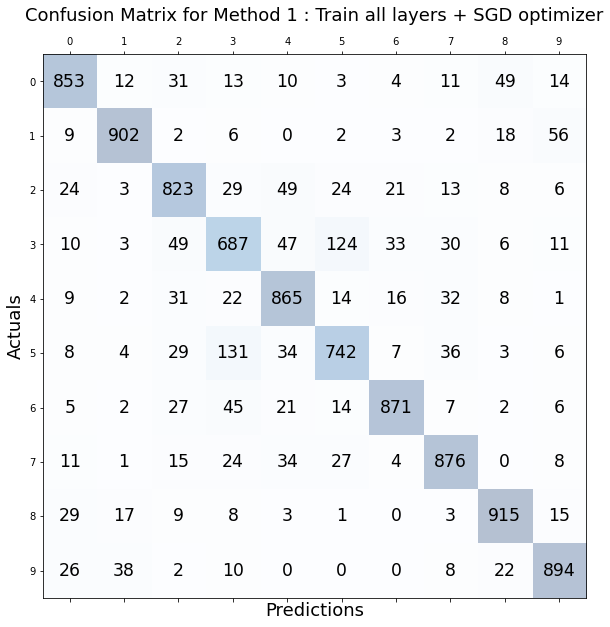

In [41]:
confusionMatrixWandb()
confusionMatrixSkLearn()

## Method 2 : Train all layers + Adam optimizer

In [42]:
full_finetune = True
use_sgd = False
learning_rate = 0.01

# Run the cell containing train() and test() function

In [45]:
best_acc = 0
for epoch in range(0, num_epochs):    
    # train and eval step.
    print('\nEpoch: %d' % epoch)
    print("Training")
    train(epoch, optimizer)
    print("Testing")
    test(epoch)  


Epoch: 0
Training


  0%|          | 1/391 [00:00<01:54,  3.41it/s]

Train Epoch: 0 [0/50000 (0%)]	Loss: 14.192492


 26%|██▌       | 102/391 [00:09<00:26, 11.09it/s]

Train Epoch: 0 [12800/50000 (26%)]	Loss: 2.022012


 52%|█████▏    | 202/391 [00:18<00:17, 10.88it/s]

Train Epoch: 0 [25600/50000 (51%)]	Loss: 2.428382


 77%|███████▋  | 302/391 [00:27<00:08, 11.02it/s]

Train Epoch: 0 [38400/50000 (77%)]	Loss: 2.050633


100%|██████████| 391/391 [00:35<00:00, 10.97it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.09it/s]



Test set: Average loss: 0.0211, Accuracy: 2857/10000 (29%)


Epoch: 1
Training


  0%|          | 1/391 [00:00<03:16,  1.99it/s]

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.952414


 26%|██▌       | 102/391 [00:09<00:26, 11.02it/s]

Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.884454


 52%|█████▏    | 202/391 [00:18<00:17, 10.92it/s]

Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.545928


 77%|███████▋  | 302/391 [00:27<00:08, 10.76it/s]

Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.657875


100%|██████████| 391/391 [00:35<00:00, 10.92it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.83it/s]



Test set: Average loss: 0.0155, Accuracy: 4393/10000 (44%)


Epoch: 2
Training


  1%|          | 2/391 [00:00<01:50,  3.52it/s]

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.642288


 26%|██▌       | 102/391 [00:10<00:25, 11.33it/s]

Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.399020


 52%|█████▏    | 202/391 [00:19<00:17, 11.03it/s]

Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.585641


 77%|███████▋  | 302/391 [00:28<00:08, 10.80it/s]

Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.351898


100%|██████████| 391/391 [00:36<00:00, 10.67it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.21it/s]



Test set: Average loss: 0.0152, Accuracy: 4907/10000 (49%)


Epoch: 3
Training


  1%|          | 2/391 [00:00<01:45,  3.67it/s]

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.378668


 26%|██▌       | 102/391 [00:09<00:26, 11.06it/s]

Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.556252


 52%|█████▏    | 202/391 [00:18<00:16, 11.24it/s]

Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.233787


 77%|███████▋  | 302/391 [00:28<00:07, 11.28it/s]

Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.239524


100%|██████████| 391/391 [00:36<00:00, 10.85it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.85it/s]



Test set: Average loss: 0.0120, Accuracy: 5669/10000 (57%)


Epoch: 4
Training


  1%|          | 2/391 [00:00<01:56,  3.33it/s]

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.315126


 26%|██▋       | 103/391 [00:10<00:26, 10.76it/s]

Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.287866


 52%|█████▏    | 203/391 [00:19<00:17, 10.55it/s]

Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.153834


 77%|███████▋  | 303/391 [00:28<00:07, 11.05it/s]

Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.071492


100%|██████████| 391/391 [00:36<00:00, 10.70it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.72it/s]



Test set: Average loss: 0.0108, Accuracy: 6200/10000 (62%)


Epoch: 5
Training


  0%|          | 1/391 [00:00<01:43,  3.76it/s]

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.200129


 26%|██▋       | 103/391 [00:10<00:25, 11.14it/s]

Train Epoch: 5 [12800/50000 (26%)]	Loss: 1.068227


 52%|█████▏    | 203/391 [00:18<00:16, 11.31it/s]

Train Epoch: 5 [25600/50000 (51%)]	Loss: 1.174546


 77%|███████▋  | 303/391 [00:28<00:08, 10.89it/s]

Train Epoch: 5 [38400/50000 (77%)]	Loss: 0.925771


100%|██████████| 391/391 [00:35<00:00, 10.88it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.78it/s]



Test set: Average loss: 0.0100, Accuracy: 6467/10000 (65%)


Epoch: 6
Training


  1%|          | 2/391 [00:00<01:58,  3.29it/s]

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.022782


 26%|██▌       | 102/391 [00:10<00:25, 11.17it/s]

Train Epoch: 6 [12800/50000 (26%)]	Loss: 0.962793


 52%|█████▏    | 202/391 [00:19<00:17, 11.04it/s]

Train Epoch: 6 [25600/50000 (51%)]	Loss: 1.030368


 77%|███████▋  | 302/391 [00:28<00:07, 11.14it/s]

Train Epoch: 6 [38400/50000 (77%)]	Loss: 0.938628


100%|██████████| 391/391 [00:36<00:00, 10.73it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.64it/s]



Test set: Average loss: 0.0095, Accuracy: 6675/10000 (67%)


Epoch: 7
Training


  0%|          | 1/391 [00:00<03:20,  1.95it/s]

Train Epoch: 7 [0/50000 (0%)]	Loss: 0.864876


 26%|██▌       | 102/391 [00:09<00:26, 10.96it/s]

Train Epoch: 7 [12800/50000 (26%)]	Loss: 1.221071


 52%|█████▏    | 202/391 [00:19<00:17, 11.00it/s]

Train Epoch: 7 [25600/50000 (51%)]	Loss: 0.946946


 77%|███████▋  | 302/391 [00:28<00:07, 11.26it/s]

Train Epoch: 7 [38400/50000 (77%)]	Loss: 0.957347


100%|██████████| 391/391 [00:36<00:00, 10.81it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.23it/s]



Test set: Average loss: 0.0083, Accuracy: 7161/10000 (72%)


Epoch: 8
Training


  1%|          | 2/391 [00:00<02:00,  3.24it/s]

Train Epoch: 8 [0/50000 (0%)]	Loss: 0.911987


 26%|██▌       | 102/391 [00:10<00:29,  9.86it/s]

Train Epoch: 8 [12800/50000 (26%)]	Loss: 0.759460


 52%|█████▏    | 203/391 [00:19<00:17, 10.48it/s]

Train Epoch: 8 [25600/50000 (51%)]	Loss: 0.839206


 77%|███████▋  | 303/391 [00:28<00:07, 11.01it/s]

Train Epoch: 8 [38400/50000 (77%)]	Loss: 0.835802


100%|██████████| 391/391 [00:36<00:00, 10.65it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.04it/s]



Test set: Average loss: 0.0078, Accuracy: 7308/10000 (73%)


Epoch: 9
Training


  1%|          | 2/391 [00:00<02:03,  3.15it/s]

Train Epoch: 9 [0/50000 (0%)]	Loss: 0.804728


 26%|██▌       | 102/391 [00:09<00:26, 11.11it/s]

Train Epoch: 9 [12800/50000 (26%)]	Loss: 0.595582


 52%|█████▏    | 202/391 [00:19<00:17, 10.85it/s]

Train Epoch: 9 [25600/50000 (51%)]	Loss: 0.819020


 77%|███████▋  | 302/391 [00:28<00:08, 10.77it/s]

Train Epoch: 9 [38400/50000 (77%)]	Loss: 0.803482


100%|██████████| 391/391 [00:36<00:00, 10.83it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.34it/s]



Test set: Average loss: 0.0080, Accuracy: 7340/10000 (73%)


Epoch: 10
Training


  1%|          | 2/391 [00:00<01:36,  4.01it/s]

Train Epoch: 10 [0/50000 (0%)]	Loss: 0.840753


 26%|██▌       | 102/391 [00:10<00:28, 10.13it/s]

Train Epoch: 10 [12800/50000 (26%)]	Loss: 0.813420


 52%|█████▏    | 202/391 [00:19<00:17, 11.00it/s]

Train Epoch: 10 [25600/50000 (51%)]	Loss: 0.752744


 77%|███████▋  | 302/391 [00:28<00:08, 11.00it/s]

Train Epoch: 10 [38400/50000 (77%)]	Loss: 0.735914


100%|██████████| 391/391 [00:36<00:00, 10.65it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.99it/s]



Test set: Average loss: 0.0080, Accuracy: 7281/10000 (73%)


Epoch: 11
Training


  0%|          | 1/391 [00:00<02:55,  2.23it/s]

Train Epoch: 11 [0/50000 (0%)]	Loss: 0.635162


 26%|██▋       | 103/391 [00:09<00:25, 11.14it/s]

Train Epoch: 11 [12800/50000 (26%)]	Loss: 0.631948


 52%|█████▏    | 203/391 [00:18<00:17, 10.88it/s]

Train Epoch: 11 [25600/50000 (51%)]	Loss: 0.843568


 77%|███████▋  | 303/391 [00:27<00:07, 11.02it/s]

Train Epoch: 11 [38400/50000 (77%)]	Loss: 0.861352


100%|██████████| 391/391 [00:35<00:00, 10.96it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.54it/s]



Test set: Average loss: 0.0074, Accuracy: 7454/10000 (75%)


Epoch: 12
Training


  1%|          | 2/391 [00:00<01:47,  3.63it/s]

Train Epoch: 12 [0/50000 (0%)]	Loss: 0.809053


 26%|██▌       | 102/391 [00:09<00:25, 11.24it/s]

Train Epoch: 12 [12800/50000 (26%)]	Loss: 0.765562


 52%|█████▏    | 202/391 [00:19<00:16, 11.19it/s]

Train Epoch: 12 [25600/50000 (51%)]	Loss: 0.620958


 77%|███████▋  | 302/391 [00:28<00:07, 11.40it/s]

Train Epoch: 12 [38400/50000 (77%)]	Loss: 0.853392


100%|██████████| 391/391 [00:36<00:00, 10.75it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.16it/s]



Test set: Average loss: 0.0068, Accuracy: 7681/10000 (77%)


Epoch: 13
Training


  1%|          | 2/391 [00:00<01:45,  3.70it/s]

Train Epoch: 13 [0/50000 (0%)]	Loss: 0.706920


 26%|██▋       | 103/391 [00:10<00:26, 10.84it/s]

Train Epoch: 13 [12800/50000 (26%)]	Loss: 0.642654


 52%|█████▏    | 203/391 [00:19<00:16, 11.12it/s]

Train Epoch: 13 [25600/50000 (51%)]	Loss: 0.761320


 77%|███████▋  | 303/391 [00:28<00:08, 10.96it/s]

Train Epoch: 13 [38400/50000 (77%)]	Loss: 0.668742


100%|██████████| 391/391 [00:36<00:00, 10.86it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.12it/s]


Test set: Average loss: 0.0069, Accuracy: 7643/10000 (76%)


Epoch: 14
Training



  1%|          | 3/391 [00:00<01:07,  5.72it/s]

Train Epoch: 14 [0/50000 (0%)]	Loss: 0.560226


 26%|██▌       | 102/391 [00:09<00:26, 10.95it/s]

Train Epoch: 14 [12800/50000 (26%)]	Loss: 0.702256


 52%|█████▏    | 203/391 [00:19<00:17, 11.02it/s]

Train Epoch: 14 [25600/50000 (51%)]	Loss: 0.734081


 77%|███████▋  | 303/391 [00:28<00:08, 10.97it/s]

Train Epoch: 14 [38400/50000 (77%)]	Loss: 0.587345


100%|██████████| 391/391 [00:36<00:00, 10.82it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.49it/s]



Test set: Average loss: 0.0067, Accuracy: 7696/10000 (77%)


Epoch: 15
Training


  1%|          | 2/391 [00:00<01:49,  3.54it/s]

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.526362


 26%|██▋       | 103/391 [00:10<00:25, 11.36it/s]

Train Epoch: 15 [12800/50000 (26%)]	Loss: 0.584269


 52%|█████▏    | 203/391 [00:19<00:17, 10.63it/s]

Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.582911


 77%|███████▋  | 303/391 [00:28<00:07, 11.23it/s]

Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.693265


100%|██████████| 391/391 [00:36<00:00, 10.80it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 28.32it/s]



Test set: Average loss: 0.0064, Accuracy: 7849/10000 (78%)


Epoch: 16
Training


  1%|          | 2/391 [00:00<01:57,  3.31it/s]

Train Epoch: 16 [0/50000 (0%)]	Loss: 0.582336


 26%|██▌       | 102/391 [00:09<00:26, 11.05it/s]

Train Epoch: 16 [12800/50000 (26%)]	Loss: 0.815148


 52%|█████▏    | 202/391 [00:19<00:17, 11.06it/s]

Train Epoch: 16 [25600/50000 (51%)]	Loss: 0.541825


 77%|███████▋  | 302/391 [00:28<00:08, 10.96it/s]

Train Epoch: 16 [38400/50000 (77%)]	Loss: 0.569035


100%|██████████| 391/391 [00:36<00:00, 10.70it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.90it/s]


Test set: Average loss: 0.0064, Accuracy: 7805/10000 (78%)


Epoch: 17
Training



  0%|          | 1/391 [00:00<02:53,  2.24it/s]

Train Epoch: 17 [0/50000 (0%)]	Loss: 0.404239


 26%|██▌       | 102/391 [00:09<00:26, 11.00it/s]

Train Epoch: 17 [12800/50000 (26%)]	Loss: 0.592172


 52%|█████▏    | 202/391 [00:18<00:17, 10.90it/s]

Train Epoch: 17 [25600/50000 (51%)]	Loss: 0.616572


 77%|███████▋  | 302/391 [00:27<00:07, 11.22it/s]

Train Epoch: 17 [38400/50000 (77%)]	Loss: 0.653045


100%|██████████| 391/391 [00:35<00:00, 10.88it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.73it/s]



Test set: Average loss: 0.0063, Accuracy: 7874/10000 (79%)


Epoch: 18
Training


  0%|          | 1/391 [00:00<02:50,  2.29it/s]

Train Epoch: 18 [0/50000 (0%)]	Loss: 0.551564


 26%|██▋       | 103/391 [00:10<00:25, 11.32it/s]

Train Epoch: 18 [12800/50000 (26%)]	Loss: 0.671859


 52%|█████▏    | 203/391 [00:19<00:17, 10.78it/s]

Train Epoch: 18 [25600/50000 (51%)]	Loss: 0.561303


 77%|███████▋  | 303/391 [00:28<00:08, 10.98it/s]

Train Epoch: 18 [38400/50000 (77%)]	Loss: 0.419271


100%|██████████| 391/391 [00:36<00:00, 10.68it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.29it/s]



Test set: Average loss: 0.0060, Accuracy: 7968/10000 (80%)


Epoch: 19
Training


  0%|          | 1/391 [00:00<03:10,  2.05it/s]

Train Epoch: 19 [0/50000 (0%)]	Loss: 0.478997


 26%|██▋       | 103/391 [00:10<00:25, 11.11it/s]

Train Epoch: 19 [12800/50000 (26%)]	Loss: 0.544236


 52%|█████▏    | 203/391 [00:19<00:17, 10.81it/s]

Train Epoch: 19 [25600/50000 (51%)]	Loss: 0.400077


 77%|███████▋  | 303/391 [00:28<00:07, 11.02it/s]

Train Epoch: 19 [38400/50000 (77%)]	Loss: 0.585662


100%|██████████| 391/391 [00:36<00:00, 10.83it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.62it/s]



Test set: Average loss: 0.0061, Accuracy: 7974/10000 (80%)


Epoch: 20
Training


  1%|          | 2/391 [00:00<01:50,  3.53it/s]

Train Epoch: 20 [0/50000 (0%)]	Loss: 0.436448


 26%|██▋       | 103/391 [00:10<00:25, 11.22it/s]

Train Epoch: 20 [12800/50000 (26%)]	Loss: 0.600718


 52%|█████▏    | 203/391 [00:19<00:16, 11.09it/s]

Train Epoch: 20 [25600/50000 (51%)]	Loss: 0.478082


 77%|███████▋  | 303/391 [00:28<00:08, 10.70it/s]

Train Epoch: 20 [38400/50000 (77%)]	Loss: 0.629246


100%|██████████| 391/391 [00:36<00:00, 10.66it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Test set: Average loss: 0.0061, Accuracy: 7930/10000 (79%)


Epoch: 21
Training



  1%|          | 3/391 [00:00<01:16,  5.07it/s]

Train Epoch: 21 [0/50000 (0%)]	Loss: 0.480935


 26%|██▋       | 103/391 [00:09<00:26, 11.02it/s]

Train Epoch: 21 [12800/50000 (26%)]	Loss: 0.434995


 52%|█████▏    | 203/391 [00:18<00:17, 10.58it/s]

Train Epoch: 21 [25600/50000 (51%)]	Loss: 0.514593


 77%|███████▋  | 303/391 [00:27<00:07, 11.11it/s]

Train Epoch: 21 [38400/50000 (77%)]	Loss: 0.527803


100%|██████████| 391/391 [00:35<00:00, 10.88it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.53it/s]


Test set: Average loss: 0.0062, Accuracy: 7907/10000 (79%)


Epoch: 22
Training



  1%|          | 2/391 [00:00<01:39,  3.92it/s]

Train Epoch: 22 [0/50000 (0%)]	Loss: 0.472845


 26%|██▋       | 103/391 [00:09<00:26, 10.99it/s]

Train Epoch: 22 [12800/50000 (26%)]	Loss: 0.543226


 52%|█████▏    | 203/391 [00:19<00:23,  8.04it/s]

Train Epoch: 22 [25600/50000 (51%)]	Loss: 0.453384


 77%|███████▋  | 303/391 [00:28<00:08, 10.45it/s]

Train Epoch: 22 [38400/50000 (77%)]	Loss: 0.594810


100%|██████████| 391/391 [00:36<00:00, 10.74it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.48it/s]



Test set: Average loss: 0.0058, Accuracy: 8092/10000 (81%)


Epoch: 23
Training


  1%|          | 2/391 [00:00<01:44,  3.72it/s]

Train Epoch: 23 [0/50000 (0%)]	Loss: 0.438533


 26%|██▋       | 103/391 [00:10<00:25, 11.30it/s]

Train Epoch: 23 [12800/50000 (26%)]	Loss: 0.439396


 52%|█████▏    | 203/391 [00:19<00:16, 11.43it/s]

Train Epoch: 23 [25600/50000 (51%)]	Loss: 0.636136


 77%|███████▋  | 303/391 [00:28<00:08, 10.75it/s]

Train Epoch: 23 [38400/50000 (77%)]	Loss: 0.484320


100%|██████████| 391/391 [00:36<00:00, 10.74it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.55it/s]


Test set: Average loss: 0.0059, Accuracy: 8058/10000 (81%)


Epoch: 24
Training



  1%|          | 2/391 [00:00<01:38,  3.96it/s]

Train Epoch: 24 [0/50000 (0%)]	Loss: 0.434059


 26%|██▌       | 102/391 [00:09<00:26, 10.89it/s]

Train Epoch: 24 [12800/50000 (26%)]	Loss: 0.537011


 52%|█████▏    | 202/391 [00:18<00:17, 11.00it/s]

Train Epoch: 24 [25600/50000 (51%)]	Loss: 0.764094


 77%|███████▋  | 302/391 [00:28<00:07, 11.28it/s]

Train Epoch: 24 [38400/50000 (77%)]	Loss: 0.380352


100%|██████████| 391/391 [00:36<00:00, 10.82it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.30it/s]



Test set: Average loss: 0.0056, Accuracy: 8103/10000 (81%)


Epoch: 25
Training


  1%|          | 2/391 [00:00<01:51,  3.49it/s]

Train Epoch: 25 [0/50000 (0%)]	Loss: 0.654058


 26%|██▋       | 103/391 [00:10<00:26, 11.00it/s]

Train Epoch: 25 [12800/50000 (26%)]	Loss: 0.418128


 52%|█████▏    | 203/391 [00:19<00:16, 11.43it/s]

Train Epoch: 25 [25600/50000 (51%)]	Loss: 0.613449


 77%|███████▋  | 303/391 [00:28<00:07, 11.27it/s]

Train Epoch: 25 [38400/50000 (77%)]	Loss: 0.468505


100%|██████████| 391/391 [00:36<00:00, 10.76it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.33it/s]


Test set: Average loss: 0.0058, Accuracy: 8055/10000 (81%)


Epoch: 26
Training



  1%|          | 2/391 [00:00<01:45,  3.70it/s]

Train Epoch: 26 [0/50000 (0%)]	Loss: 0.359721


 26%|██▋       | 103/391 [00:09<00:26, 11.01it/s]

Train Epoch: 26 [12800/50000 (26%)]	Loss: 0.564898


 52%|█████▏    | 203/391 [00:18<00:17, 10.78it/s]

Train Epoch: 26 [25600/50000 (51%)]	Loss: 0.515556


 77%|███████▋  | 303/391 [00:28<00:08, 10.69it/s]

Train Epoch: 26 [38400/50000 (77%)]	Loss: 0.382969


100%|██████████| 391/391 [00:36<00:00, 10.77it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.85it/s]



Test set: Average loss: 0.0059, Accuracy: 8095/10000 (81%)


Epoch: 27
Training


  1%|          | 2/391 [00:00<01:42,  3.79it/s]

Train Epoch: 27 [0/50000 (0%)]	Loss: 0.409486


 26%|██▋       | 103/391 [00:09<00:26, 10.77it/s]

Train Epoch: 27 [12800/50000 (26%)]	Loss: 0.554620


 52%|█████▏    | 203/391 [00:18<00:16, 11.32it/s]

Train Epoch: 27 [25600/50000 (51%)]	Loss: 0.299278


 77%|███████▋  | 303/391 [00:27<00:07, 11.24it/s]

Train Epoch: 27 [38400/50000 (77%)]	Loss: 0.404543


100%|██████████| 391/391 [00:35<00:00, 10.90it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.09it/s]


Test set: Average loss: 0.0060, Accuracy: 8016/10000 (80%)


Epoch: 28
Training



  1%|          | 2/391 [00:00<01:38,  3.95it/s]

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.310590


 26%|██▌       | 102/391 [00:09<00:25, 11.26it/s]

Train Epoch: 28 [12800/50000 (26%)]	Loss: 0.374303


 52%|█████▏    | 202/391 [00:18<00:17, 11.12it/s]

Train Epoch: 28 [25600/50000 (51%)]	Loss: 0.335053


 77%|███████▋  | 303/391 [00:28<00:08, 10.63it/s]

Train Epoch: 28 [38400/50000 (77%)]	Loss: 0.422632


100%|██████████| 391/391 [00:36<00:00, 10.75it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.21it/s]



Test set: Average loss: 0.0055, Accuracy: 8173/10000 (82%)


Epoch: 29
Training


  1%|          | 2/391 [00:00<01:46,  3.65it/s]

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.440846


 26%|██▌       | 102/391 [00:09<00:26, 11.04it/s]

Train Epoch: 29 [12800/50000 (26%)]	Loss: 0.293041


 52%|█████▏    | 202/391 [00:18<00:16, 11.31it/s]

Train Epoch: 29 [25600/50000 (51%)]	Loss: 0.445140


 77%|███████▋  | 302/391 [00:28<00:07, 11.19it/s]

Train Epoch: 29 [38400/50000 (77%)]	Loss: 0.345368


100%|██████████| 391/391 [00:36<00:00, 10.82it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.37it/s]


Test set: Average loss: 0.0057, Accuracy: 8085/10000 (81%)


Epoch: 30
Training



  1%|          | 2/391 [00:00<01:39,  3.92it/s]

Train Epoch: 30 [0/50000 (0%)]	Loss: 0.408449


 26%|██▌       | 102/391 [00:09<00:27, 10.68it/s]

Train Epoch: 30 [12800/50000 (26%)]	Loss: 0.391469


 52%|█████▏    | 202/391 [00:18<00:16, 11.15it/s]

Train Epoch: 30 [25600/50000 (51%)]	Loss: 0.550945


 77%|███████▋  | 302/391 [00:28<00:07, 11.20it/s]

Train Epoch: 30 [38400/50000 (77%)]	Loss: 0.423472


100%|██████████| 391/391 [00:36<00:00, 10.73it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.26it/s]


Test set: Average loss: 0.0058, Accuracy: 8129/10000 (81%)


Epoch: 31
Training



  1%|          | 2/391 [00:00<01:37,  3.99it/s]

Train Epoch: 31 [0/50000 (0%)]	Loss: 0.296451


 26%|██▋       | 103/391 [00:09<00:27, 10.46it/s]

Train Epoch: 31 [12800/50000 (26%)]	Loss: 0.524210


 52%|█████▏    | 203/391 [00:19<00:17, 10.71it/s]

Train Epoch: 31 [25600/50000 (51%)]	Loss: 0.558839


 77%|███████▋  | 303/391 [00:28<00:08, 10.71it/s]

Train Epoch: 31 [38400/50000 (77%)]	Loss: 0.437185


100%|██████████| 391/391 [00:36<00:00, 10.81it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.21it/s]



Test set: Average loss: 0.0056, Accuracy: 8210/10000 (82%)


Epoch: 32
Training


  1%|          | 2/391 [00:00<01:38,  3.96it/s]

Train Epoch: 32 [0/50000 (0%)]	Loss: 0.346450


 26%|██▌       | 102/391 [00:10<00:26, 11.06it/s]

Train Epoch: 32 [12800/50000 (26%)]	Loss: 0.495684


 52%|█████▏    | 202/391 [00:19<00:17, 11.08it/s]

Train Epoch: 32 [25600/50000 (51%)]	Loss: 0.462961


 77%|███████▋  | 303/391 [00:28<00:08, 10.67it/s]

Train Epoch: 32 [38400/50000 (77%)]	Loss: 0.404592


100%|██████████| 391/391 [00:36<00:00, 10.65it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.64it/s]


Test set: Average loss: 0.0058, Accuracy: 8126/10000 (81%)


Epoch: 33
Training



  1%|          | 2/391 [00:00<01:39,  3.90it/s]

Train Epoch: 33 [0/50000 (0%)]	Loss: 0.370628


 26%|██▋       | 103/391 [00:09<00:26, 10.79it/s]

Train Epoch: 33 [12800/50000 (26%)]	Loss: 0.393991


 52%|█████▏    | 203/391 [00:18<00:17, 10.59it/s]

Train Epoch: 33 [25600/50000 (51%)]	Loss: 0.399643


 77%|███████▋  | 303/391 [00:27<00:07, 11.11it/s]

Train Epoch: 33 [38400/50000 (77%)]	Loss: 0.745124


100%|██████████| 391/391 [00:35<00:00, 10.94it/s]


Testing


100%|██████████| 100/100 [00:03<00:00, 27.93it/s]


Test set: Average loss: 0.0063, Accuracy: 8027/10000 (80%)


Epoch: 34
Training



  1%|          | 3/391 [00:00<01:07,  5.74it/s]

Train Epoch: 34 [0/50000 (0%)]	Loss: 0.873107


 26%|██▌       | 102/391 [00:09<00:26, 11.06it/s]

Train Epoch: 34 [12800/50000 (26%)]	Loss: 0.417753


 52%|█████▏    | 202/391 [00:18<00:17, 10.88it/s]

Train Epoch: 34 [25600/50000 (51%)]	Loss: 0.482610


 77%|███████▋  | 302/391 [00:27<00:08, 11.08it/s]

Train Epoch: 34 [38400/50000 (77%)]	Loss: 0.483476


100%|██████████| 391/391 [00:36<00:00, 10.85it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.78it/s]


Test set: Average loss: 0.0060, Accuracy: 8056/10000 (81%)


Epoch: 35
Training



  1%|          | 2/391 [00:00<01:40,  3.85it/s]

Train Epoch: 35 [0/50000 (0%)]	Loss: 0.502004


 26%|██▌       | 102/391 [00:09<00:25, 11.21it/s]

Train Epoch: 35 [12800/50000 (26%)]	Loss: 0.544723


 52%|█████▏    | 202/391 [00:18<00:17, 11.00it/s]

Train Epoch: 35 [25600/50000 (51%)]	Loss: 0.393669


 77%|███████▋  | 302/391 [00:27<00:07, 11.20it/s]

Train Epoch: 35 [38400/50000 (77%)]	Loss: 0.491494


100%|██████████| 391/391 [00:35<00:00, 10.93it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.51it/s]


Test set: Average loss: 0.0054, Accuracy: 8165/10000 (82%)


Epoch: 36
Training



  1%|          | 3/391 [00:00<01:12,  5.36it/s]

Train Epoch: 36 [0/50000 (0%)]	Loss: 0.299636


 26%|██▌       | 102/391 [00:09<00:25, 11.31it/s]

Train Epoch: 36 [12800/50000 (26%)]	Loss: 0.374729


 52%|█████▏    | 202/391 [00:18<00:17, 10.78it/s]

Train Epoch: 36 [25600/50000 (51%)]	Loss: 0.536028


 77%|███████▋  | 302/391 [00:27<00:08, 10.88it/s]

Train Epoch: 36 [38400/50000 (77%)]	Loss: 0.406901


100%|██████████| 391/391 [00:36<00:00, 10.79it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.78it/s]



Test set: Average loss: 0.0054, Accuracy: 8221/10000 (82%)


Epoch: 37
Training


  1%|          | 2/391 [00:00<01:52,  3.46it/s]

Train Epoch: 37 [0/50000 (0%)]	Loss: 0.447134


 26%|██▋       | 103/391 [00:10<00:25, 11.23it/s]

Train Epoch: 37 [12800/50000 (26%)]	Loss: 0.278555


 52%|█████▏    | 203/391 [00:19<00:16, 11.21it/s]

Train Epoch: 37 [25600/50000 (51%)]	Loss: 0.427817


 77%|███████▋  | 303/391 [00:28<00:07, 11.20it/s]

Train Epoch: 37 [38400/50000 (77%)]	Loss: 0.315467


100%|██████████| 391/391 [00:36<00:00, 10.81it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.09it/s]



Test set: Average loss: 0.0052, Accuracy: 8325/10000 (83%)


Epoch: 38
Training


  0%|          | 1/391 [00:00<02:43,  2.38it/s]

Train Epoch: 38 [0/50000 (0%)]	Loss: 0.417781


 26%|██▌       | 102/391 [00:10<00:25, 11.31it/s]

Train Epoch: 38 [12800/50000 (26%)]	Loss: 0.488921


 52%|█████▏    | 202/391 [00:19<00:16, 11.14it/s]

Train Epoch: 38 [25600/50000 (51%)]	Loss: 0.332883


 77%|███████▋  | 302/391 [00:28<00:08, 10.90it/s]

Train Epoch: 38 [38400/50000 (77%)]	Loss: 0.412121


100%|██████████| 391/391 [00:36<00:00, 10.66it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.18it/s]


Test set: Average loss: 0.0053, Accuracy: 8325/10000 (83%)


Epoch: 39
Training



  1%|          | 2/391 [00:00<01:34,  4.13it/s]

Train Epoch: 39 [0/50000 (0%)]	Loss: 0.335040


 26%|██▌       | 102/391 [00:09<00:27, 10.45it/s]

Train Epoch: 39 [12800/50000 (26%)]	Loss: 0.334599


 52%|█████▏    | 202/391 [00:18<00:16, 11.22it/s]

Train Epoch: 39 [25600/50000 (51%)]	Loss: 0.272609


 77%|███████▋  | 302/391 [00:27<00:08, 11.05it/s]

Train Epoch: 39 [38400/50000 (77%)]	Loss: 0.442142


100%|██████████| 391/391 [00:35<00:00, 10.92it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.52it/s]


Test set: Average loss: 0.0055, Accuracy: 8212/10000 (82%)


Epoch: 40
Training



  1%|          | 2/391 [00:00<01:28,  4.39it/s]

Train Epoch: 40 [0/50000 (0%)]	Loss: 0.332404


 26%|██▋       | 103/391 [00:09<00:26, 11.00it/s]

Train Epoch: 40 [12800/50000 (26%)]	Loss: 0.406303


 52%|█████▏    | 203/391 [00:18<00:16, 11.07it/s]

Train Epoch: 40 [25600/50000 (51%)]	Loss: 0.291121


 77%|███████▋  | 303/391 [00:27<00:07, 11.08it/s]

Train Epoch: 40 [38400/50000 (77%)]	Loss: 0.448627


100%|██████████| 391/391 [00:36<00:00, 10.76it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.90it/s]


Test set: Average loss: 0.0054, Accuracy: 8257/10000 (83%)


Epoch: 41
Training



  1%|          | 2/391 [00:00<01:50,  3.51it/s]

Train Epoch: 41 [0/50000 (0%)]	Loss: 0.272840


 26%|██▋       | 103/391 [00:09<00:26, 10.81it/s]

Train Epoch: 41 [12800/50000 (26%)]	Loss: 0.409613


 52%|█████▏    | 203/391 [00:19<00:17, 10.82it/s]

Train Epoch: 41 [25600/50000 (51%)]	Loss: 0.335290


 77%|███████▋  | 303/391 [00:28<00:07, 11.01it/s]

Train Epoch: 41 [38400/50000 (77%)]	Loss: 0.349624


100%|██████████| 391/391 [00:36<00:00, 10.79it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


Test set: Average loss: 0.0053, Accuracy: 8268/10000 (83%)


Epoch: 42
Training



  1%|          | 2/391 [00:00<01:56,  3.34it/s]

Train Epoch: 42 [0/50000 (0%)]	Loss: 0.285190


 26%|██▋       | 103/391 [00:09<00:26, 10.94it/s]

Train Epoch: 42 [12800/50000 (26%)]	Loss: 0.299783


 52%|█████▏    | 203/391 [00:18<00:16, 11.28it/s]

Train Epoch: 42 [25600/50000 (51%)]	Loss: 0.363282


 77%|███████▋  | 303/391 [00:28<00:08, 10.68it/s]

Train Epoch: 42 [38400/50000 (77%)]	Loss: 0.439872


100%|██████████| 391/391 [00:36<00:00, 10.73it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.94it/s]


Test set: Average loss: 0.0057, Accuracy: 8236/10000 (82%)


Epoch: 43
Training



  0%|          | 1/391 [00:00<03:02,  2.14it/s]

Train Epoch: 43 [0/50000 (0%)]	Loss: 0.305353


 26%|██▌       | 102/391 [00:09<00:26, 10.89it/s]

Train Epoch: 43 [12800/50000 (26%)]	Loss: 0.297056


 52%|█████▏    | 202/391 [00:18<00:17, 10.85it/s]

Train Epoch: 43 [25600/50000 (51%)]	Loss: 0.292802


 77%|███████▋  | 302/391 [00:28<00:08, 11.02it/s]

Train Epoch: 43 [38400/50000 (77%)]	Loss: 0.282423


100%|██████████| 391/391 [00:36<00:00, 10.84it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


Test set: Average loss: 0.0057, Accuracy: 8190/10000 (82%)


Epoch: 44
Training



  0%|          | 1/391 [00:00<02:19,  2.79it/s]

Train Epoch: 44 [0/50000 (0%)]	Loss: 0.332117


 26%|██▋       | 103/391 [00:09<00:26, 11.02it/s]

Train Epoch: 44 [12800/50000 (26%)]	Loss: 0.211477


 52%|█████▏    | 203/391 [00:18<00:16, 11.12it/s]

Train Epoch: 44 [25600/50000 (51%)]	Loss: 0.293598


 77%|███████▋  | 303/391 [00:27<00:08, 10.79it/s]

Train Epoch: 44 [38400/50000 (77%)]	Loss: 0.343239


100%|██████████| 391/391 [00:35<00:00, 10.93it/s]

Testing



100%|██████████| 100/100 [00:04<00:00, 24.53it/s]



Test set: Average loss: 0.0052, Accuracy: 8352/10000 (84%)


Epoch: 45
Training


  1%|          | 2/391 [00:00<01:51,  3.47it/s]

Train Epoch: 45 [0/50000 (0%)]	Loss: 0.223331


 26%|██▌       | 102/391 [00:10<00:25, 11.31it/s]

Train Epoch: 45 [12800/50000 (26%)]	Loss: 0.456838


 52%|█████▏    | 202/391 [00:19<00:16, 11.33it/s]

Train Epoch: 45 [25600/50000 (51%)]	Loss: 0.509459


 77%|███████▋  | 302/391 [00:28<00:07, 11.28it/s]

Train Epoch: 45 [38400/50000 (77%)]	Loss: 0.304207


100%|██████████| 391/391 [00:36<00:00, 10.83it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.50it/s]


Test set: Average loss: 0.0053, Accuracy: 8308/10000 (83%)


Epoch: 46
Training



  1%|          | 2/391 [00:00<01:42,  3.80it/s]

Train Epoch: 46 [0/50000 (0%)]	Loss: 0.265870


 26%|██▋       | 103/391 [00:09<00:26, 10.80it/s]

Train Epoch: 46 [12800/50000 (26%)]	Loss: 0.335162


 52%|█████▏    | 203/391 [00:18<00:17, 10.83it/s]

Train Epoch: 46 [25600/50000 (51%)]	Loss: 0.306818


 77%|███████▋  | 303/391 [00:28<00:08, 10.96it/s]

Train Epoch: 46 [38400/50000 (77%)]	Loss: 0.335860


100%|██████████| 391/391 [00:35<00:00, 10.88it/s]

Testing



100%|██████████| 100/100 [00:04<00:00, 23.88it/s]



Test set: Average loss: 0.0057, Accuracy: 8220/10000 (82%)


Epoch: 47
Training


  1%|          | 2/391 [00:00<01:51,  3.49it/s]

Train Epoch: 47 [0/50000 (0%)]	Loss: 0.395406


 26%|██▋       | 103/391 [00:09<00:26, 10.91it/s]

Train Epoch: 47 [12800/50000 (26%)]	Loss: 0.236180


 52%|█████▏    | 203/391 [00:18<00:17, 10.98it/s]

Train Epoch: 47 [25600/50000 (51%)]	Loss: 0.359211


 77%|███████▋  | 303/391 [00:28<00:07, 11.20it/s]

Train Epoch: 47 [38400/50000 (77%)]	Loss: 0.446225


100%|██████████| 391/391 [00:36<00:00, 10.83it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.17it/s]


Test set: Average loss: 0.0055, Accuracy: 8281/10000 (83%)


Epoch: 48
Training



  1%|          | 3/391 [00:00<01:15,  5.15it/s]

Train Epoch: 48 [0/50000 (0%)]	Loss: 0.389097


 26%|██▋       | 103/391 [00:09<00:25, 11.27it/s]

Train Epoch: 48 [12800/50000 (26%)]	Loss: 0.347145


 52%|█████▏    | 203/391 [00:18<00:17, 10.73it/s]

Train Epoch: 48 [25600/50000 (51%)]	Loss: 0.366547


 77%|███████▋  | 302/391 [00:27<00:07, 11.30it/s]

Train Epoch: 48 [38400/50000 (77%)]	Loss: 0.300236


100%|██████████| 391/391 [00:36<00:00, 10.82it/s]

Testing



100%|██████████| 100/100 [00:04<00:00, 24.38it/s]



Test set: Average loss: 0.0053, Accuracy: 8345/10000 (83%)


Epoch: 49
Training


  1%|          | 3/391 [00:00<01:11,  5.42it/s]

Train Epoch: 49 [0/50000 (0%)]	Loss: 0.195258


 26%|██▋       | 103/391 [00:09<00:26, 10.99it/s]

Train Epoch: 49 [12800/50000 (26%)]	Loss: 0.425388


 52%|█████▏    | 203/391 [00:18<00:17, 11.03it/s]

Train Epoch: 49 [25600/50000 (51%)]	Loss: 0.356982


 77%|███████▋  | 303/391 [00:28<00:08, 10.87it/s]

Train Epoch: 49 [38400/50000 (77%)]	Loss: 0.367119


100%|██████████| 391/391 [00:36<00:00, 10.85it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.14it/s]


Test set: Average loss: 0.0054, Accuracy: 8341/10000 (83%)



Printing confusion matrix in wandb
(10000,)
(10000,)
Plotting confusion matrix : 
torch.Size([10000, 1])
torch.Size([10000, 1])
Class labels in order :  ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


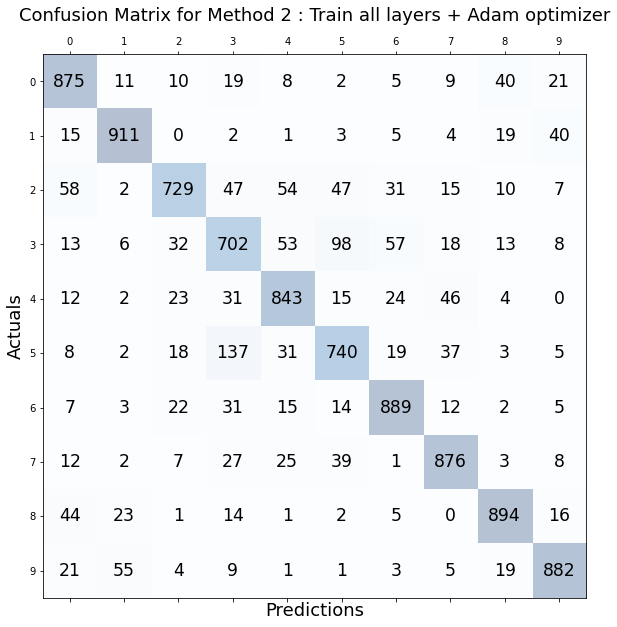

In [46]:
confusionMatrixWandb()
confusionMatrixSkLearn()

## Method 3 : Freeze all + Finetune last layer + SGD optimizer

In [52]:
full_finetune = False
use_sgd = True
learning_rate = 0.001

# Run the cell containing train() and test() function

In [55]:
best_acc = 0
for epoch in range(0, num_epochs):    
    # train and eval step.
    print('\nEpoch: %d' % epoch)
    print("Training")
    train(epoch, optimizer)
    print("Testing")
    test(epoch)  


Epoch: 0
Training


  1%|          | 3/391 [00:00<00:33, 11.65it/s]

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.793998


 27%|██▋       | 104/391 [00:06<00:17, 16.27it/s]

Train Epoch: 0 [12800/50000 (26%)]	Loss: 2.008507


 52%|█████▏    | 203/391 [00:12<00:11, 15.90it/s]

Train Epoch: 0 [25600/50000 (51%)]	Loss: 1.888935


 77%|███████▋  | 302/391 [00:18<00:05, 15.70it/s]

Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.795237


100%|██████████| 391/391 [00:24<00:00, 16.11it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.83it/s]



Test set: Average loss: 1.7923, Accuracy: 3736/10000 (37%)


Epoch: 1
Training


  0%|          | 1/391 [00:00<03:06,  2.09it/s]

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.902357


 26%|██▌       | 102/391 [00:07<00:18, 15.33it/s]

Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.691164


 52%|█████▏    | 202/391 [00:13<00:12, 15.58it/s]

Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.849737


 77%|███████▋  | 303/391 [00:19<00:05, 15.77it/s]

Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.769729


100%|██████████| 391/391 [00:25<00:00, 15.60it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.08it/s]



Test set: Average loss: 1.7329, Accuracy: 4007/10000 (40%)


Epoch: 2
Training


  0%|          | 1/391 [00:00<03:06,  2.09it/s]

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.696206


 27%|██▋       | 104/391 [00:07<00:17, 16.17it/s]

Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.650051


 52%|█████▏    | 202/391 [00:13<00:11, 16.74it/s]

Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.702657


 78%|███████▊  | 304/391 [00:19<00:05, 16.02it/s]

Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.630851


100%|██████████| 391/391 [00:25<00:00, 15.54it/s]


Testing


100%|██████████| 100/100 [00:03<00:00, 26.72it/s]



Test set: Average loss: 1.7249, Accuracy: 4010/10000 (40%)


Epoch: 3
Training


  0%|          | 1/391 [00:00<01:44,  3.71it/s]

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.780926


 26%|██▋       | 103/391 [00:07<00:15, 18.48it/s]

Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.817896


 52%|█████▏    | 204/391 [00:13<00:11, 16.52it/s]

Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.616144


 78%|███████▊  | 304/391 [00:19<00:05, 15.18it/s]

Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.569513


100%|██████████| 391/391 [00:24<00:00, 15.66it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.12it/s]



Test set: Average loss: 1.7070, Accuracy: 4050/10000 (40%)


Epoch: 4
Training


  1%|          | 3/391 [00:00<01:17,  4.99it/s]

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.741253


 26%|██▋       | 103/391 [00:07<00:17, 16.37it/s]

Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.635641


 52%|█████▏    | 203/391 [00:13<00:11, 16.42it/s]

Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.594078


 78%|███████▊  | 304/391 [00:19<00:05, 16.93it/s]

Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.566259


100%|██████████| 391/391 [00:25<00:00, 15.40it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.95it/s]


Test set: Average loss: 1.7165, Accuracy: 4020/10000 (40%)


Epoch: 5
Training



  1%|          | 3/391 [00:00<00:57,  6.74it/s]

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.578676


 26%|██▋       | 103/391 [00:06<00:17, 16.14it/s]

Train Epoch: 5 [12800/50000 (26%)]	Loss: 1.767191


 52%|█████▏    | 203/391 [00:13<00:12, 15.50it/s]

Train Epoch: 5 [25600/50000 (51%)]	Loss: 1.581373


 77%|███████▋  | 303/391 [00:19<00:05, 15.26it/s]

Train Epoch: 5 [38400/50000 (77%)]	Loss: 1.626802


100%|██████████| 391/391 [00:24<00:00, 15.70it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.37it/s]



Test set: Average loss: 1.6985, Accuracy: 4149/10000 (41%)


Epoch: 6
Training


  0%|          | 1/391 [00:00<03:01,  2.15it/s]

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.681913


 27%|██▋       | 104/391 [00:07<00:19, 15.04it/s]

Train Epoch: 6 [12800/50000 (26%)]	Loss: 1.719483


 52%|█████▏    | 202/391 [00:13<00:11, 15.76it/s]

Train Epoch: 6 [25600/50000 (51%)]	Loss: 1.748191


 77%|███████▋  | 303/391 [00:20<00:05, 16.05it/s]

Train Epoch: 6 [38400/50000 (77%)]	Loss: 1.658041


100%|██████████| 391/391 [00:25<00:00, 15.35it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.76it/s]


Test set: Average loss: 1.6976, Accuracy: 4147/10000 (41%)


Epoch: 7
Training



  1%|          | 3/391 [00:00<00:53,  7.20it/s]

Train Epoch: 7 [0/50000 (0%)]	Loss: 1.773894


 26%|██▌       | 102/391 [00:06<00:17, 16.37it/s]

Train Epoch: 7 [12800/50000 (26%)]	Loss: 1.746669


 52%|█████▏    | 203/391 [00:12<00:12, 15.19it/s]

Train Epoch: 7 [25600/50000 (51%)]	Loss: 1.783587


 77%|███████▋  | 303/391 [00:19<00:05, 16.55it/s]

Train Epoch: 7 [38400/50000 (77%)]	Loss: 1.620844


100%|██████████| 391/391 [00:24<00:00, 15.87it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.26it/s]



Test set: Average loss: 1.6873, Accuracy: 4170/10000 (42%)


Epoch: 8
Training


  0%|          | 1/391 [00:00<01:19,  4.90it/s]

Train Epoch: 8 [0/50000 (0%)]	Loss: 1.729595


 26%|██▋       | 103/391 [00:07<00:18, 15.87it/s]

Train Epoch: 8 [12800/50000 (26%)]	Loss: 1.652142


 52%|█████▏    | 203/391 [00:13<00:11, 15.85it/s]

Train Epoch: 8 [25600/50000 (51%)]	Loss: 1.569017


 77%|███████▋  | 302/391 [00:19<00:05, 14.98it/s]

Train Epoch: 8 [38400/50000 (77%)]	Loss: 1.707556


100%|██████████| 391/391 [00:25<00:00, 15.46it/s]


Testing


100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Test set: Average loss: 1.6982, Accuracy: 4107/10000 (41%)


Epoch: 9
Training



  1%|          | 3/391 [00:00<00:51,  7.59it/s]

Train Epoch: 9 [0/50000 (0%)]	Loss: 1.703358


 27%|██▋       | 104/391 [00:06<00:18, 15.67it/s]

Train Epoch: 9 [12800/50000 (26%)]	Loss: 1.709297


 52%|█████▏    | 204/391 [00:12<00:11, 16.02it/s]

Train Epoch: 9 [25600/50000 (51%)]	Loss: 1.598331


 77%|███████▋  | 302/391 [00:19<00:05, 16.36it/s]

Train Epoch: 9 [38400/50000 (77%)]	Loss: 1.581396


100%|██████████| 391/391 [00:24<00:00, 15.87it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.65it/s]


Test set: Average loss: 1.6995, Accuracy: 4121/10000 (41%)


Epoch: 10
Training



  1%|          | 3/391 [00:00<00:54,  7.09it/s]

Train Epoch: 10 [0/50000 (0%)]	Loss: 1.763110


 27%|██▋       | 104/391 [00:07<00:18, 15.39it/s]

Train Epoch: 10 [12800/50000 (26%)]	Loss: 1.571329


 52%|█████▏    | 204/391 [00:13<00:12, 15.08it/s]

Train Epoch: 10 [25600/50000 (51%)]	Loss: 1.500469


 77%|███████▋  | 302/391 [00:19<00:05, 14.99it/s]

Train Epoch: 10 [38400/50000 (77%)]	Loss: 1.596004


100%|██████████| 391/391 [00:25<00:00, 15.33it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.74it/s]


Test set: Average loss: 1.6905, Accuracy: 4099/10000 (41%)


Epoch: 11
Training



  1%|          | 3/391 [00:00<00:47,  8.18it/s]

Train Epoch: 11 [0/50000 (0%)]	Loss: 1.707728


 26%|██▋       | 103/391 [00:06<00:19, 14.77it/s]

Train Epoch: 11 [12800/50000 (26%)]	Loss: 1.542515


 52%|█████▏    | 203/391 [00:13<00:11, 16.53it/s]

Train Epoch: 11 [25600/50000 (51%)]	Loss: 1.587976


 77%|███████▋  | 303/391 [00:19<00:06, 14.26it/s]

Train Epoch: 11 [38400/50000 (77%)]	Loss: 1.572662


100%|██████████| 391/391 [00:24<00:00, 15.66it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.48it/s]


Test set: Average loss: 1.6883, Accuracy: 4143/10000 (41%)


Epoch: 12
Training



  1%|          | 3/391 [00:00<00:48,  8.00it/s]

Train Epoch: 12 [0/50000 (0%)]	Loss: 1.705882


 26%|██▋       | 103/391 [00:06<00:17, 16.68it/s]

Train Epoch: 12 [12800/50000 (26%)]	Loss: 1.679562


 52%|█████▏    | 203/391 [00:13<00:12, 15.17it/s]

Train Epoch: 12 [25600/50000 (51%)]	Loss: 1.534917


 77%|███████▋  | 302/391 [00:19<00:06, 14.80it/s]

Train Epoch: 12 [38400/50000 (77%)]	Loss: 1.594539


100%|██████████| 391/391 [00:25<00:00, 15.47it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.69it/s]



Test set: Average loss: 1.6849, Accuracy: 4192/10000 (42%)


Epoch: 13
Training


  0%|          | 1/391 [00:00<03:05,  2.10it/s]

Train Epoch: 13 [0/50000 (0%)]	Loss: 1.669275


 26%|██▌       | 102/391 [00:07<00:18, 15.74it/s]

Train Epoch: 13 [12800/50000 (26%)]	Loss: 1.635836


 52%|█████▏    | 202/391 [00:13<00:12, 15.00it/s]

Train Epoch: 13 [25600/50000 (51%)]	Loss: 1.675953


 78%|███████▊  | 304/391 [00:19<00:05, 16.65it/s]

Train Epoch: 13 [38400/50000 (77%)]	Loss: 1.738276


100%|██████████| 391/391 [00:25<00:00, 15.48it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.64it/s]


Test set: Average loss: 1.6750, Accuracy: 4164/10000 (42%)


Epoch: 14
Training



  1%|          | 2/391 [00:00<01:04,  6.00it/s]

Train Epoch: 14 [0/50000 (0%)]	Loss: 1.734245


 27%|██▋       | 104/391 [00:06<00:18, 15.79it/s]

Train Epoch: 14 [12800/50000 (26%)]	Loss: 1.551446


 52%|█████▏    | 202/391 [00:13<00:12, 15.53it/s]

Train Epoch: 14 [25600/50000 (51%)]	Loss: 1.729459


 77%|███████▋  | 303/391 [00:19<00:05, 15.41it/s]

Train Epoch: 14 [38400/50000 (77%)]	Loss: 1.575917


100%|██████████| 391/391 [00:25<00:00, 15.32it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.22it/s]


Test set: Average loss: 1.6926, Accuracy: 4176/10000 (42%)


Epoch: 15
Training



  1%|          | 4/391 [00:00<00:39,  9.83it/s]

Train Epoch: 15 [0/50000 (0%)]	Loss: 1.756185


 26%|██▋       | 103/391 [00:06<00:18, 15.94it/s]

Train Epoch: 15 [12800/50000 (26%)]	Loss: 1.655567


 52%|█████▏    | 203/391 [00:13<00:12, 15.07it/s]

Train Epoch: 15 [25600/50000 (51%)]	Loss: 1.601645


 77%|███████▋  | 303/391 [00:19<00:05, 15.61it/s]

Train Epoch: 15 [38400/50000 (77%)]	Loss: 1.713644


100%|██████████| 391/391 [00:24<00:00, 15.73it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.88it/s]



Test set: Average loss: 1.6772, Accuracy: 4202/10000 (42%)


Epoch: 16
Training


  0%|          | 1/391 [00:00<03:06,  2.09it/s]

Train Epoch: 16 [0/50000 (0%)]	Loss: 1.714753


 26%|██▋       | 103/391 [00:07<00:18, 15.55it/s]

Train Epoch: 16 [12800/50000 (26%)]	Loss: 1.668908


 52%|█████▏    | 203/391 [00:14<00:11, 15.91it/s]

Train Epoch: 16 [25600/50000 (51%)]	Loss: 1.582904


 77%|███████▋  | 303/391 [00:20<00:05, 15.75it/s]

Train Epoch: 16 [38400/50000 (77%)]	Loss: 1.568955


100%|██████████| 391/391 [00:25<00:00, 15.15it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.55it/s]



Test set: Average loss: 1.6791, Accuracy: 4212/10000 (42%)


Epoch: 17
Training


  0%|          | 1/391 [00:00<02:58,  2.19it/s]

Train Epoch: 17 [0/50000 (0%)]	Loss: 1.595960


 26%|██▌       | 102/391 [00:07<00:18, 16.04it/s]

Train Epoch: 17 [12800/50000 (26%)]	Loss: 1.673304


 52%|█████▏    | 203/391 [00:13<00:12, 15.18it/s]

Train Epoch: 17 [25600/50000 (51%)]	Loss: 1.674710


 77%|███████▋  | 303/391 [00:19<00:05, 14.83it/s]

Train Epoch: 17 [38400/50000 (77%)]	Loss: 1.501363


100%|██████████| 391/391 [00:25<00:00, 15.46it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Test set: Average loss: 1.6818, Accuracy: 4138/10000 (41%)


Epoch: 18
Training



  1%|          | 4/391 [00:00<00:41,  9.42it/s]

Train Epoch: 18 [0/50000 (0%)]	Loss: 1.556867


 26%|██▋       | 103/391 [00:06<00:17, 16.65it/s]

Train Epoch: 18 [12800/50000 (26%)]	Loss: 1.647768


 52%|█████▏    | 202/391 [00:13<00:11, 16.22it/s]

Train Epoch: 18 [25600/50000 (51%)]	Loss: 1.615335


 77%|███████▋  | 303/391 [00:19<00:05, 15.98it/s]

Train Epoch: 18 [38400/50000 (77%)]	Loss: 1.683818


100%|██████████| 391/391 [00:25<00:00, 15.56it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.79it/s]


Test set: Average loss: 1.6883, Accuracy: 4165/10000 (42%)


Epoch: 19
Training



  1%|          | 4/391 [00:00<00:37, 10.33it/s]

Train Epoch: 19 [0/50000 (0%)]	Loss: 1.588697


 26%|██▋       | 103/391 [00:06<00:18, 15.50it/s]

Train Epoch: 19 [12800/50000 (26%)]	Loss: 1.564545


 52%|█████▏    | 202/391 [00:13<00:12, 14.93it/s]

Train Epoch: 19 [25600/50000 (51%)]	Loss: 1.645716


 78%|███████▊  | 304/391 [00:19<00:05, 15.21it/s]

Train Epoch: 19 [38400/50000 (77%)]	Loss: 1.699634


100%|██████████| 391/391 [00:24<00:00, 15.80it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.77it/s]


Test set: Average loss: 1.6948, Accuracy: 4133/10000 (41%)


Epoch: 20
Training



  1%|          | 3/391 [00:00<00:48,  7.93it/s]

Train Epoch: 20 [0/50000 (0%)]	Loss: 1.654237


 26%|██▋       | 103/391 [00:06<00:17, 16.23it/s]

Train Epoch: 20 [12800/50000 (26%)]	Loss: 1.533368


 52%|█████▏    | 203/391 [00:13<00:11, 16.06it/s]

Train Epoch: 20 [25600/50000 (51%)]	Loss: 1.631912


 78%|███████▊  | 304/391 [00:19<00:05, 15.56it/s]

Train Epoch: 20 [38400/50000 (77%)]	Loss: 1.619233


100%|██████████| 391/391 [00:25<00:00, 15.57it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.24it/s]


Test set: Average loss: 1.6814, Accuracy: 4210/10000 (42%)


Epoch: 21
Training



  1%|          | 4/391 [00:00<00:38, 10.13it/s]

Train Epoch: 21 [0/50000 (0%)]	Loss: 1.683661


 27%|██▋       | 104/391 [00:06<00:18, 15.20it/s]

Train Epoch: 21 [12800/50000 (26%)]	Loss: 1.557429


 51%|█████▏    | 201/391 [00:13<00:11, 16.52it/s]

Train Epoch: 21 [25600/50000 (51%)]	Loss: 1.656631


 77%|███████▋  | 302/391 [00:19<00:06, 14.83it/s]

Train Epoch: 21 [38400/50000 (77%)]	Loss: 1.711299


100%|██████████| 391/391 [00:25<00:00, 15.62it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.50it/s]



Test set: Average loss: 1.6723, Accuracy: 4229/10000 (42%)


Epoch: 22
Training


  1%|          | 2/391 [00:00<01:08,  5.64it/s]

Train Epoch: 22 [0/50000 (0%)]	Loss: 1.553823


 26%|██▋       | 103/391 [00:07<00:17, 16.24it/s]

Train Epoch: 22 [12800/50000 (26%)]	Loss: 1.694445


 52%|█████▏    | 205/391 [00:14<00:14, 12.43it/s]

Train Epoch: 22 [25600/50000 (51%)]	Loss: 1.818327


 78%|███████▊  | 304/391 [00:20<00:05, 16.41it/s]

Train Epoch: 22 [38400/50000 (77%)]	Loss: 1.626625


100%|██████████| 391/391 [00:25<00:00, 15.22it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.27it/s]


Test set: Average loss: 1.6923, Accuracy: 4200/10000 (42%)


Epoch: 23
Training



  1%|          | 4/391 [00:00<00:44,  8.64it/s]

Train Epoch: 23 [0/50000 (0%)]	Loss: 1.724223


 26%|██▋       | 103/391 [00:06<00:19, 14.72it/s]

Train Epoch: 23 [12800/50000 (26%)]	Loss: 1.643338


 52%|█████▏    | 202/391 [00:13<00:12, 15.07it/s]

Train Epoch: 23 [25600/50000 (51%)]	Loss: 1.664440


 77%|███████▋  | 302/391 [00:19<00:06, 14.28it/s]

Train Epoch: 23 [38400/50000 (77%)]	Loss: 1.669910


100%|██████████| 391/391 [00:25<00:00, 15.47it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.39it/s]



Test set: Average loss: 1.6742, Accuracy: 4230/10000 (42%)


Epoch: 24
Training


  0%|          | 1/391 [00:00<02:13,  2.93it/s]

Train Epoch: 24 [0/50000 (0%)]	Loss: 1.649183


 26%|██▋       | 103/391 [00:07<00:18, 15.36it/s]

Train Epoch: 24 [12800/50000 (26%)]	Loss: 1.711897


 52%|█████▏    | 203/391 [00:13<00:13, 14.40it/s]

Train Epoch: 24 [25600/50000 (51%)]	Loss: 1.684758


 77%|███████▋  | 303/391 [00:20<00:05, 16.23it/s]

Train Epoch: 24 [38400/50000 (77%)]	Loss: 1.613049


100%|██████████| 391/391 [00:26<00:00, 15.01it/s]


Testing


100%|██████████| 100/100 [00:03<00:00, 26.71it/s]


Test set: Average loss: 1.6832, Accuracy: 4219/10000 (42%)


Epoch: 25
Training



  1%|          | 3/391 [00:00<00:50,  7.62it/s]

Train Epoch: 25 [0/50000 (0%)]	Loss: 1.764869


 26%|██▋       | 103/391 [00:06<00:19, 14.72it/s]

Train Epoch: 25 [12800/50000 (26%)]	Loss: 1.643853


 52%|█████▏    | 204/391 [00:12<00:11, 16.09it/s]

Train Epoch: 25 [25600/50000 (51%)]	Loss: 1.689668


 77%|███████▋  | 302/391 [00:19<00:05, 14.93it/s]

Train Epoch: 25 [38400/50000 (77%)]	Loss: 1.726941


100%|██████████| 391/391 [00:24<00:00, 15.71it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.98it/s]


Test set: Average loss: 1.6842, Accuracy: 4208/10000 (42%)


Epoch: 26
Training



  1%|          | 3/391 [00:00<00:56,  6.87it/s]

Train Epoch: 26 [0/50000 (0%)]	Loss: 1.481497


 26%|██▋       | 103/391 [00:06<00:18, 15.69it/s]

Train Epoch: 26 [12800/50000 (26%)]	Loss: 1.752457


 52%|█████▏    | 204/391 [00:13<00:10, 17.02it/s]

Train Epoch: 26 [25600/50000 (51%)]	Loss: 1.695501


 77%|███████▋  | 302/391 [00:20<00:05, 14.84it/s]

Train Epoch: 26 [38400/50000 (77%)]	Loss: 1.525380


100%|██████████| 391/391 [00:25<00:00, 15.14it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.44it/s]



Test set: Average loss: 1.6770, Accuracy: 4222/10000 (42%)


Epoch: 27
Training


  1%|          | 3/391 [00:00<00:55,  7.02it/s]

Train Epoch: 27 [0/50000 (0%)]	Loss: 1.595057


 26%|██▋       | 103/391 [00:06<00:19, 14.98it/s]

Train Epoch: 27 [12800/50000 (26%)]	Loss: 1.568116


 52%|█████▏    | 203/391 [00:13<00:12, 15.30it/s]

Train Epoch: 27 [25600/50000 (51%)]	Loss: 1.629715


 77%|███████▋  | 303/391 [00:19<00:05, 15.87it/s]

Train Epoch: 27 [38400/50000 (77%)]	Loss: 1.760538


100%|██████████| 391/391 [00:25<00:00, 15.44it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.48it/s]


Test set: Average loss: 1.6879, Accuracy: 4192/10000 (42%)


Epoch: 28
Training



  1%|          | 4/391 [00:00<00:40,  9.64it/s]

Train Epoch: 28 [0/50000 (0%)]	Loss: 1.506670


 26%|██▋       | 103/391 [00:06<00:19, 14.70it/s]

Train Epoch: 28 [12800/50000 (26%)]	Loss: 1.582796


 52%|█████▏    | 203/391 [00:13<00:11, 16.06it/s]

Train Epoch: 28 [25600/50000 (51%)]	Loss: 1.515797


 77%|███████▋  | 303/391 [00:19<00:05, 15.18it/s]

Train Epoch: 28 [38400/50000 (77%)]	Loss: 1.659609


100%|██████████| 391/391 [00:25<00:00, 15.25it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.17it/s]



Test set: Average loss: 1.6756, Accuracy: 4266/10000 (43%)


Epoch: 29
Training


  1%|          | 2/391 [00:00<01:29,  4.33it/s]

Train Epoch: 29 [0/50000 (0%)]	Loss: 1.672929


 26%|██▋       | 103/391 [00:07<00:18, 15.64it/s]

Train Epoch: 29 [12800/50000 (26%)]	Loss: 1.441483


 52%|█████▏    | 204/391 [00:13<00:11, 15.85it/s]

Train Epoch: 29 [25600/50000 (51%)]	Loss: 1.668097


 78%|███████▊  | 304/391 [00:20<00:05, 16.49it/s]

Train Epoch: 29 [38400/50000 (77%)]	Loss: 1.767224


100%|██████████| 391/391 [00:25<00:00, 15.15it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.36it/s]



Test set: Average loss: 1.6842, Accuracy: 4230/10000 (42%)


Epoch: 30
Training


  1%|          | 2/391 [00:00<01:24,  4.62it/s]

Train Epoch: 30 [0/50000 (0%)]	Loss: 1.733967


 27%|██▋       | 104/391 [00:07<00:17, 16.25it/s]

Train Epoch: 30 [12800/50000 (26%)]	Loss: 1.670838


 52%|█████▏    | 203/391 [00:13<00:11, 16.03it/s]

Train Epoch: 30 [25600/50000 (51%)]	Loss: 1.685987


 77%|███████▋  | 303/391 [00:20<00:05, 14.99it/s]

Train Epoch: 30 [38400/50000 (77%)]	Loss: 1.611757


100%|██████████| 391/391 [00:25<00:00, 15.15it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.47it/s]



Test set: Average loss: 1.6909, Accuracy: 4179/10000 (42%)


Epoch: 31
Training


  1%|          | 3/391 [00:00<01:08,  5.70it/s]

Train Epoch: 31 [0/50000 (0%)]	Loss: 1.668015


 26%|██▌       | 102/391 [00:07<00:19, 15.14it/s]

Train Epoch: 31 [12800/50000 (26%)]	Loss: 1.552649


 52%|█████▏    | 204/391 [00:13<00:11, 16.08it/s]

Train Epoch: 31 [25600/50000 (51%)]	Loss: 1.744993


 77%|███████▋  | 302/391 [00:19<00:06, 14.18it/s]

Train Epoch: 31 [38400/50000 (77%)]	Loss: 1.568580


100%|██████████| 391/391 [00:25<00:00, 15.24it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.08it/s]


Test set: Average loss: 1.6811, Accuracy: 4153/10000 (42%)


Epoch: 32
Training



  1%|          | 4/391 [00:00<00:45,  8.59it/s]

Train Epoch: 32 [0/50000 (0%)]	Loss: 1.632829


 26%|██▌       | 102/391 [00:06<00:17, 16.82it/s]

Train Epoch: 32 [12800/50000 (26%)]	Loss: 1.512296


 52%|█████▏    | 204/391 [00:13<00:11, 15.63it/s]

Train Epoch: 32 [25600/50000 (51%)]	Loss: 1.670459


 77%|███████▋  | 303/391 [00:20<00:06, 14.26it/s]

Train Epoch: 32 [38400/50000 (77%)]	Loss: 1.648758


100%|██████████| 391/391 [00:25<00:00, 15.34it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.77it/s]


Test set: Average loss: 1.6851, Accuracy: 4215/10000 (42%)


Epoch: 33
Training



  1%|          | 3/391 [00:00<00:56,  6.91it/s]

Train Epoch: 33 [0/50000 (0%)]	Loss: 1.518299


 26%|██▌       | 102/391 [00:06<00:19, 14.80it/s]

Train Epoch: 33 [12800/50000 (26%)]	Loss: 1.716760


 52%|█████▏    | 204/391 [00:13<00:10, 18.01it/s]

Train Epoch: 33 [25600/50000 (51%)]	Loss: 1.485539


 77%|███████▋  | 303/391 [00:19<00:05, 15.81it/s]

Train Epoch: 33 [38400/50000 (77%)]	Loss: 1.683577


100%|██████████| 391/391 [00:25<00:00, 15.40it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.06it/s]


Test set: Average loss: 1.6944, Accuracy: 4183/10000 (42%)


Epoch: 34
Training



  1%|          | 3/391 [00:00<01:01,  6.32it/s]

Train Epoch: 34 [0/50000 (0%)]	Loss: 1.599805


 26%|██▋       | 103/391 [00:06<00:17, 16.10it/s]

Train Epoch: 34 [12800/50000 (26%)]	Loss: 1.719388


 52%|█████▏    | 202/391 [00:13<00:12, 15.63it/s]

Train Epoch: 34 [25600/50000 (51%)]	Loss: 1.555060


 77%|███████▋  | 302/391 [00:19<00:06, 14.39it/s]

Train Epoch: 34 [38400/50000 (77%)]	Loss: 1.539218


100%|██████████| 391/391 [00:25<00:00, 15.08it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.61it/s]


Test set: Average loss: 1.6912, Accuracy: 4177/10000 (42%)


Epoch: 35
Training



  1%|          | 4/391 [00:00<00:41,  9.36it/s]

Train Epoch: 35 [0/50000 (0%)]	Loss: 1.656410


 27%|██▋       | 104/391 [00:06<00:18, 15.29it/s]

Train Epoch: 35 [12800/50000 (26%)]	Loss: 1.853009


 52%|█████▏    | 203/391 [00:13<00:13, 13.48it/s]

Train Epoch: 35 [25600/50000 (51%)]	Loss: 1.563144


 77%|███████▋  | 302/391 [00:19<00:05, 15.28it/s]

Train Epoch: 35 [38400/50000 (77%)]	Loss: 1.695057


100%|██████████| 391/391 [00:25<00:00, 15.31it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 25.98it/s]


Test set: Average loss: 1.6902, Accuracy: 4168/10000 (42%)


Epoch: 36
Training



  1%|          | 4/391 [00:00<00:41,  9.33it/s]

Train Epoch: 36 [0/50000 (0%)]	Loss: 1.639128


 26%|██▋       | 103/391 [00:06<00:17, 16.30it/s]

Train Epoch: 36 [12800/50000 (26%)]	Loss: 1.601676


 52%|█████▏    | 202/391 [00:13<00:11, 15.78it/s]

Train Epoch: 36 [25600/50000 (51%)]	Loss: 1.731718


 78%|███████▊  | 304/391 [00:19<00:05, 15.71it/s]

Train Epoch: 36 [38400/50000 (77%)]	Loss: 1.603514


100%|██████████| 391/391 [00:25<00:00, 15.16it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 25.93it/s]


Test set: Average loss: 1.6988, Accuracy: 4171/10000 (42%)


Epoch: 37
Training



  1%|          | 3/391 [00:00<00:47,  8.17it/s]

Train Epoch: 37 [0/50000 (0%)]	Loss: 1.710609


 26%|██▋       | 103/391 [00:06<00:19, 14.74it/s]

Train Epoch: 37 [12800/50000 (26%)]	Loss: 1.686605


 52%|█████▏    | 203/391 [00:13<00:12, 14.95it/s]

Train Epoch: 37 [25600/50000 (51%)]	Loss: 1.541950


 78%|███████▊  | 304/391 [00:19<00:05, 15.62it/s]

Train Epoch: 37 [38400/50000 (77%)]	Loss: 1.613439


100%|██████████| 391/391 [00:25<00:00, 15.44it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 25.75it/s]


Test set: Average loss: 1.6917, Accuracy: 4178/10000 (42%)


Epoch: 38
Training



  1%|          | 3/391 [00:00<00:58,  6.69it/s]

Train Epoch: 38 [0/50000 (0%)]	Loss: 1.484598


 26%|██▋       | 103/391 [00:06<00:17, 16.46it/s]

Train Epoch: 38 [12800/50000 (26%)]	Loss: 1.588230


 52%|█████▏    | 203/391 [00:13<00:12, 15.36it/s]

Train Epoch: 38 [25600/50000 (51%)]	Loss: 1.702521


 77%|███████▋  | 302/391 [00:19<00:05, 15.98it/s]

Train Epoch: 38 [38400/50000 (77%)]	Loss: 1.581741


100%|██████████| 391/391 [00:25<00:00, 15.09it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.19it/s]



Test set: Average loss: 1.6764, Accuracy: 4216/10000 (42%)


Epoch: 39
Training


  1%|          | 4/391 [00:00<00:44,  8.74it/s]

Train Epoch: 39 [0/50000 (0%)]	Loss: 1.642390


 27%|██▋       | 104/391 [00:06<00:17, 16.41it/s]

Train Epoch: 39 [12800/50000 (26%)]	Loss: 1.687656


 52%|█████▏    | 204/391 [00:13<00:11, 15.96it/s]

Train Epoch: 39 [25600/50000 (51%)]	Loss: 1.589702


 77%|███████▋  | 303/391 [00:19<00:06, 13.97it/s]

Train Epoch: 39 [38400/50000 (77%)]	Loss: 1.768602


100%|██████████| 391/391 [00:25<00:00, 15.22it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 25.89it/s]



Test set: Average loss: 1.6847, Accuracy: 4206/10000 (42%)


Epoch: 40
Training


  1%|          | 4/391 [00:00<00:45,  8.49it/s]

Train Epoch: 40 [0/50000 (0%)]	Loss: 1.590633


 27%|██▋       | 104/391 [00:06<00:18, 15.67it/s]

Train Epoch: 40 [12800/50000 (26%)]	Loss: 1.568087


 52%|█████▏    | 202/391 [00:13<00:12, 15.51it/s]

Train Epoch: 40 [25600/50000 (51%)]	Loss: 1.564381


 77%|███████▋  | 302/391 [00:19<00:05, 15.52it/s]

Train Epoch: 40 [38400/50000 (77%)]	Loss: 1.601611


100%|██████████| 391/391 [00:26<00:00, 15.03it/s]


Testing


100%|██████████| 100/100 [00:03<00:00, 25.74it/s]


Test set: Average loss: 1.6786, Accuracy: 4248/10000 (42%)


Epoch: 41
Training



  1%|          | 3/391 [00:00<00:52,  7.36it/s]

Train Epoch: 41 [0/50000 (0%)]	Loss: 1.563672


 26%|██▋       | 103/391 [00:06<00:17, 16.23it/s]

Train Epoch: 41 [12800/50000 (26%)]	Loss: 1.659587


 52%|█████▏    | 203/391 [00:13<00:11, 15.81it/s]

Train Epoch: 41 [25600/50000 (51%)]	Loss: 1.529931


 77%|███████▋  | 303/391 [00:19<00:06, 14.44it/s]

Train Epoch: 41 [38400/50000 (77%)]	Loss: 1.512450


100%|██████████| 391/391 [00:25<00:00, 15.41it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.16it/s]



Test set: Average loss: 1.6808, Accuracy: 4231/10000 (42%)


Epoch: 42
Training


  1%|          | 3/391 [00:00<00:59,  6.49it/s]

Train Epoch: 42 [0/50000 (0%)]	Loss: 1.600230


 27%|██▋       | 104/391 [00:07<00:18, 15.16it/s]

Train Epoch: 42 [12800/50000 (26%)]	Loss: 1.536160


 52%|█████▏    | 202/391 [00:13<00:12, 15.44it/s]

Train Epoch: 42 [25600/50000 (51%)]	Loss: 1.611022


 77%|███████▋  | 302/391 [00:19<00:05, 15.61it/s]

Train Epoch: 42 [38400/50000 (77%)]	Loss: 1.565998


100%|██████████| 391/391 [00:26<00:00, 15.04it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.96it/s]


Test set: Average loss: 1.6943, Accuracy: 4188/10000 (42%)


Epoch: 43
Training



  1%|          | 3/391 [00:00<01:02,  6.24it/s]

Train Epoch: 43 [0/50000 (0%)]	Loss: 1.567652


 26%|██▋       | 103/391 [00:07<00:19, 14.87it/s]

Train Epoch: 43 [12800/50000 (26%)]	Loss: 1.589076


 52%|█████▏    | 202/391 [00:13<00:12, 14.60it/s]

Train Epoch: 43 [25600/50000 (51%)]	Loss: 1.720941


 78%|███████▊  | 304/391 [00:20<00:05, 14.87it/s]

Train Epoch: 43 [38400/50000 (77%)]	Loss: 1.786369


100%|██████████| 391/391 [00:25<00:00, 15.15it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.40it/s]


Test set: Average loss: 1.6840, Accuracy: 4228/10000 (42%)


Epoch: 44
Training



  1%|          | 3/391 [00:00<00:57,  6.77it/s]

Train Epoch: 44 [0/50000 (0%)]	Loss: 1.638264


 26%|██▋       | 103/391 [00:06<00:18, 15.76it/s]

Train Epoch: 44 [12800/50000 (26%)]	Loss: 1.620874


 52%|█████▏    | 204/391 [00:13<00:11, 15.95it/s]

Train Epoch: 44 [25600/50000 (51%)]	Loss: 1.599737


 78%|███████▊  | 304/391 [00:20<00:05, 16.96it/s]

Train Epoch: 44 [38400/50000 (77%)]	Loss: 1.666598


100%|██████████| 391/391 [00:25<00:00, 15.18it/s]

Testing



100%|██████████| 100/100 [00:04<00:00, 23.34it/s]


Test set: Average loss: 1.6777, Accuracy: 4252/10000 (43%)


Epoch: 45
Training



  1%|          | 3/391 [00:00<00:59,  6.57it/s]

Train Epoch: 45 [0/50000 (0%)]	Loss: 1.760636


 26%|██▋       | 103/391 [00:07<00:18, 15.72it/s]

Train Epoch: 45 [12800/50000 (26%)]	Loss: 1.774758


 52%|█████▏    | 203/391 [00:13<00:12, 14.79it/s]

Train Epoch: 45 [25600/50000 (51%)]	Loss: 1.583556


 77%|███████▋  | 303/391 [00:19<00:06, 14.38it/s]

Train Epoch: 45 [38400/50000 (77%)]	Loss: 1.504584


100%|██████████| 391/391 [00:25<00:00, 15.20it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 25.99it/s]



Test set: Average loss: 1.6799, Accuracy: 4219/10000 (42%)


Epoch: 46
Training


  1%|          | 2/391 [00:00<01:12,  5.35it/s]

Train Epoch: 46 [0/50000 (0%)]	Loss: 1.644768


 26%|██▋       | 103/391 [00:06<00:18, 15.73it/s]

Train Epoch: 46 [12800/50000 (26%)]	Loss: 1.655734


 52%|█████▏    | 204/391 [00:13<00:11, 15.58it/s]

Train Epoch: 46 [25600/50000 (51%)]	Loss: 1.574017


 78%|███████▊  | 304/391 [00:19<00:05, 15.21it/s]

Train Epoch: 46 [38400/50000 (77%)]	Loss: 1.583507


100%|██████████| 391/391 [00:25<00:00, 15.20it/s]

Testing



100%|██████████| 100/100 [00:04<00:00, 23.67it/s]


Test set: Average loss: 1.6905, Accuracy: 4197/10000 (42%)


Epoch: 47
Training



  1%|          | 3/391 [00:00<00:57,  6.78it/s]

Train Epoch: 47 [0/50000 (0%)]	Loss: 1.762413


 27%|██▋       | 104/391 [00:06<00:18, 15.71it/s]

Train Epoch: 47 [12800/50000 (26%)]	Loss: 1.533656


 52%|█████▏    | 204/391 [00:13<00:11, 16.05it/s]

Train Epoch: 47 [25600/50000 (51%)]	Loss: 1.676876


 77%|███████▋  | 302/391 [00:19<00:06, 14.46it/s]

Train Epoch: 47 [38400/50000 (77%)]	Loss: 1.918593


100%|██████████| 391/391 [00:25<00:00, 15.37it/s]


Testing


100%|██████████| 100/100 [00:03<00:00, 25.99it/s]



Test set: Average loss: 1.6891, Accuracy: 4232/10000 (42%)


Epoch: 48
Training


  1%|          | 2/391 [00:00<01:35,  4.05it/s]

Train Epoch: 48 [0/50000 (0%)]	Loss: 1.591489


 26%|██▋       | 103/391 [00:07<00:17, 16.60it/s]

Train Epoch: 48 [12800/50000 (26%)]	Loss: 1.772675


 52%|█████▏    | 202/391 [00:13<00:12, 15.07it/s]

Train Epoch: 48 [25600/50000 (51%)]	Loss: 1.685817


 77%|███████▋  | 303/391 [00:20<00:05, 14.95it/s]

Train Epoch: 48 [38400/50000 (77%)]	Loss: 1.691959


100%|██████████| 391/391 [00:25<00:00, 15.18it/s]

Testing



100%|██████████| 100/100 [00:04<00:00, 24.15it/s]



Test set: Average loss: 1.6906, Accuracy: 4173/10000 (42%)


Epoch: 49
Training


  1%|          | 3/391 [00:00<01:00,  6.42it/s]

Train Epoch: 49 [0/50000 (0%)]	Loss: 1.643427


 26%|██▋       | 103/391 [00:06<00:17, 16.60it/s]

Train Epoch: 49 [12800/50000 (26%)]	Loss: 1.655548


 52%|█████▏    | 203/391 [00:13<00:12, 15.21it/s]

Train Epoch: 49 [25600/50000 (51%)]	Loss: 1.719130


 77%|███████▋  | 303/391 [00:19<00:06, 14.37it/s]

Train Epoch: 49 [38400/50000 (77%)]	Loss: 1.741925


100%|██████████| 391/391 [00:25<00:00, 15.28it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 25.65it/s]


Test set: Average loss: 1.6781, Accuracy: 4213/10000 (42%)



Printing confusion matrix in wandb
(10000,)
(10000,)
Plotting confusion matrix : 
torch.Size([10000, 1])
torch.Size([10000, 1])
Class labels in order :  ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


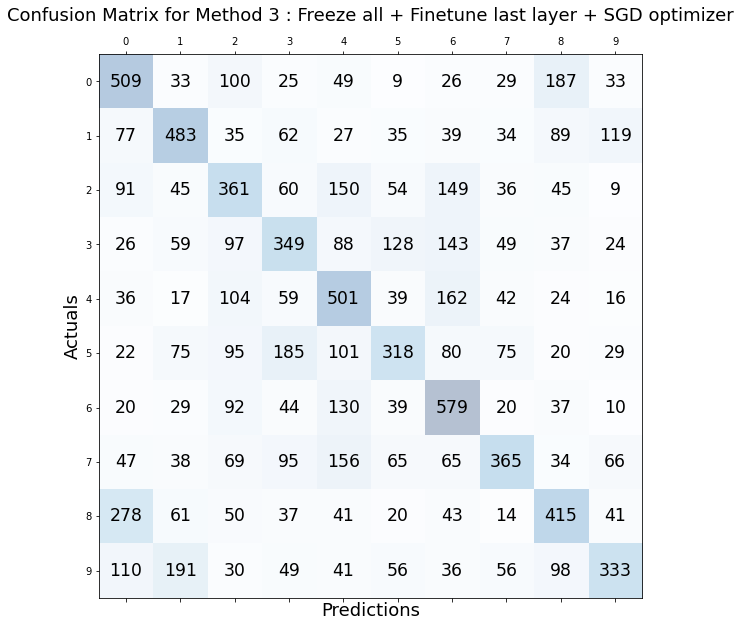

In [56]:
confusionMatrixWandb()
confusionMatrixSkLearn()

## Method 4 : Freeze all + Finetune last layer + Adam optimizer



In [57]:
full_finetune = False
use_sgd = False
learning_rate = 0.01

# Run the cell containing train() and test() function

In [60]:
best_acc = 0
for epoch in range(0, num_epochs):    
    # train and eval step.
    print('\nEpoch: %d' % epoch)
    print("Training")
    train(epoch, optimizer)
    print("Testing")
    test(epoch)  


Epoch: 0
Training


  1%|          | 3/391 [00:00<00:35, 10.86it/s]

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.937344


 26%|██▋       | 103/391 [00:06<00:18, 15.29it/s]

Train Epoch: 0 [12800/50000 (26%)]	Loss: 1.985423


 52%|█████▏    | 204/391 [00:13<00:12, 15.08it/s]

Train Epoch: 0 [25600/50000 (51%)]	Loss: 1.936952


 77%|███████▋  | 303/391 [00:19<00:05, 15.80it/s]

Train Epoch: 0 [38400/50000 (77%)]	Loss: 2.150066


100%|██████████| 391/391 [00:24<00:00, 15.67it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


Test set: Average loss: 2.1066, Accuracy: 3546/10000 (35%)


Epoch: 1
Training



  1%|          | 2/391 [00:00<01:39,  3.92it/s]

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.160310


 26%|██▋       | 103/391 [00:07<00:17, 16.55it/s]

Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.919283


 52%|█████▏    | 203/391 [00:13<00:11, 16.24it/s]

Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.919481


 77%|███████▋  | 303/391 [00:19<00:05, 15.97it/s]

Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.917511


100%|██████████| 391/391 [00:24<00:00, 15.71it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.61it/s]


Test set: Average loss: 2.2198, Accuracy: 3355/10000 (34%)


Epoch: 2
Training



  1%|          | 3/391 [00:00<00:49,  7.80it/s]

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.078819


 26%|██▋       | 103/391 [00:07<00:18, 15.27it/s]

Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.995842


 52%|█████▏    | 202/391 [00:13<00:12, 14.84it/s]

Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.083473


 78%|███████▊  | 304/391 [00:19<00:05, 16.99it/s]

Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.865315


100%|██████████| 391/391 [00:25<00:00, 15.42it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.60it/s]



Test set: Average loss: 2.1080, Accuracy: 3591/10000 (36%)


Epoch: 3
Training


  0%|          | 1/391 [00:00<02:16,  2.85it/s]

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.007542


 27%|██▋       | 104/391 [00:07<00:16, 16.93it/s]

Train Epoch: 3 [12800/50000 (26%)]	Loss: 2.041111


 52%|█████▏    | 202/391 [00:13<00:11, 16.06it/s]

Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.929466


 78%|███████▊  | 304/391 [00:19<00:05, 16.61it/s]

Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.882398


100%|██████████| 391/391 [00:25<00:00, 15.39it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.56it/s]


Test set: Average loss: 2.1456, Accuracy: 3491/10000 (35%)


Epoch: 4
Training



  1%|          | 3/391 [00:00<00:51,  7.58it/s]

Train Epoch: 4 [0/50000 (0%)]	Loss: 2.180442


 26%|██▋       | 103/391 [00:07<00:18, 15.78it/s]

Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.932973


 52%|█████▏    | 204/391 [00:13<00:11, 16.17it/s]

Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.746561


 78%|███████▊  | 304/391 [00:19<00:05, 15.91it/s]

Train Epoch: 4 [38400/50000 (77%)]	Loss: 2.004823


100%|██████████| 391/391 [00:25<00:00, 15.62it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.10it/s]


Test set: Average loss: 2.2571, Accuracy: 3374/10000 (34%)


Epoch: 5
Training



  1%|          | 3/391 [00:00<00:48,  7.93it/s]

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.985541


 26%|██▌       | 102/391 [00:06<00:17, 16.47it/s]

Train Epoch: 5 [12800/50000 (26%)]	Loss: 2.152040


 52%|█████▏    | 202/391 [00:13<00:12, 15.33it/s]

Train Epoch: 5 [25600/50000 (51%)]	Loss: 1.969689


 78%|███████▊  | 304/391 [00:19<00:05, 16.50it/s]

Train Epoch: 5 [38400/50000 (77%)]	Loss: 2.194943


100%|██████████| 391/391 [00:25<00:00, 15.63it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.43it/s]


Test set: Average loss: 2.0988, Accuracy: 3566/10000 (36%)


Epoch: 6
Training



  1%|          | 3/391 [00:00<00:52,  7.45it/s]

Train Epoch: 6 [0/50000 (0%)]	Loss: 2.022907


 27%|██▋       | 104/391 [00:07<00:17, 15.99it/s]

Train Epoch: 6 [12800/50000 (26%)]	Loss: 2.090224


 52%|█████▏    | 203/391 [00:13<00:10, 17.24it/s]

Train Epoch: 6 [25600/50000 (51%)]	Loss: 2.406072


 78%|███████▊  | 304/391 [00:19<00:05, 15.63it/s]

Train Epoch: 6 [38400/50000 (77%)]	Loss: 2.211958


100%|██████████| 391/391 [00:25<00:00, 15.44it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Test set: Average loss: 2.2516, Accuracy: 3537/10000 (35%)


Epoch: 7
Training



  1%|          | 3/391 [00:00<01:00,  6.38it/s]

Train Epoch: 7 [0/50000 (0%)]	Loss: 2.050236


 26%|██▋       | 103/391 [00:06<00:18, 15.84it/s]

Train Epoch: 7 [12800/50000 (26%)]	Loss: 2.092453


 52%|█████▏    | 203/391 [00:13<00:12, 15.63it/s]

Train Epoch: 7 [25600/50000 (51%)]	Loss: 2.305588


 77%|███████▋  | 302/391 [00:19<00:06, 14.49it/s]

Train Epoch: 7 [38400/50000 (77%)]	Loss: 2.166910


100%|██████████| 391/391 [00:25<00:00, 15.52it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.65it/s]


Test set: Average loss: 2.1717, Accuracy: 3563/10000 (36%)


Epoch: 8
Training



  1%|          | 3/391 [00:00<00:59,  6.50it/s]

Train Epoch: 8 [0/50000 (0%)]	Loss: 2.169951


 26%|██▋       | 103/391 [00:07<00:18, 15.73it/s]

Train Epoch: 8 [12800/50000 (26%)]	Loss: 1.896166


 52%|█████▏    | 203/391 [00:13<00:11, 16.49it/s]

Train Epoch: 8 [25600/50000 (51%)]	Loss: 2.054351


 77%|███████▋  | 303/391 [00:19<00:05, 15.24it/s]

Train Epoch: 8 [38400/50000 (77%)]	Loss: 2.129773


100%|██████████| 391/391 [00:25<00:00, 15.38it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.61it/s]



Test set: Average loss: 2.1039, Accuracy: 3585/10000 (36%)


Epoch: 9
Training


  1%|          | 4/391 [00:00<00:39,  9.77it/s]

Train Epoch: 9 [0/50000 (0%)]	Loss: 2.040167


 26%|██▌       | 102/391 [00:06<00:18, 15.77it/s]

Train Epoch: 9 [12800/50000 (26%)]	Loss: 2.026514


 52%|█████▏    | 202/391 [00:13<00:12, 15.60it/s]

Train Epoch: 9 [25600/50000 (51%)]	Loss: 1.969841


 77%|███████▋  | 302/391 [00:19<00:05, 16.05it/s]

Train Epoch: 9 [38400/50000 (77%)]	Loss: 1.956281


100%|██████████| 391/391 [00:24<00:00, 15.75it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Test set: Average loss: 2.2538, Accuracy: 3374/10000 (34%)


Epoch: 10
Training



  1%|          | 3/391 [00:00<00:58,  6.66it/s]

Train Epoch: 10 [0/50000 (0%)]	Loss: 2.207557


 26%|██▋       | 103/391 [00:07<00:19, 14.51it/s]

Train Epoch: 10 [12800/50000 (26%)]	Loss: 1.742703


 52%|█████▏    | 203/391 [00:13<00:12, 14.83it/s]

Train Epoch: 10 [25600/50000 (51%)]	Loss: 2.178381


 77%|███████▋  | 303/391 [00:19<00:05, 15.58it/s]

Train Epoch: 10 [38400/50000 (77%)]	Loss: 1.966329


100%|██████████| 391/391 [00:25<00:00, 15.55it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.44it/s]


Test set: Average loss: 2.3975, Accuracy: 3333/10000 (33%)


Epoch: 11
Training



  1%|          | 3/391 [00:00<00:46,  8.26it/s]

Train Epoch: 11 [0/50000 (0%)]	Loss: 2.248951


 26%|██▋       | 103/391 [00:06<00:17, 16.22it/s]

Train Epoch: 11 [12800/50000 (26%)]	Loss: 1.810480


 52%|█████▏    | 204/391 [00:13<00:12, 15.39it/s]

Train Epoch: 11 [25600/50000 (51%)]	Loss: 2.238556


 77%|███████▋  | 302/391 [00:19<00:06, 14.64it/s]

Train Epoch: 11 [38400/50000 (77%)]	Loss: 2.082485


100%|██████████| 391/391 [00:24<00:00, 15.75it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.62it/s]



Test set: Average loss: 2.1277, Accuracy: 3653/10000 (37%)


Epoch: 12
Training


  1%|          | 2/391 [00:00<01:33,  4.17it/s]

Train Epoch: 12 [0/50000 (0%)]	Loss: 2.065827


 26%|██▌       | 102/391 [00:07<00:18, 15.41it/s]

Train Epoch: 12 [12800/50000 (26%)]	Loss: 2.007919


 52%|█████▏    | 203/391 [00:13<00:11, 15.78it/s]

Train Epoch: 12 [25600/50000 (51%)]	Loss: 2.132057


 77%|███████▋  | 303/391 [00:20<00:05, 15.37it/s]

Train Epoch: 12 [38400/50000 (77%)]	Loss: 1.977186


100%|██████████| 391/391 [00:25<00:00, 15.10it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.82it/s]


Test set: Average loss: 2.1520, Accuracy: 3419/10000 (34%)


Epoch: 13
Training



  1%|          | 4/391 [00:00<00:40,  9.64it/s]

Train Epoch: 13 [0/50000 (0%)]	Loss: 2.038580


 26%|██▋       | 103/391 [00:06<00:17, 16.14it/s]

Train Epoch: 13 [12800/50000 (26%)]	Loss: 2.018788


 52%|█████▏    | 204/391 [00:13<00:12, 15.01it/s]

Train Epoch: 13 [25600/50000 (51%)]	Loss: 1.970073


 78%|███████▊  | 304/391 [00:19<00:05, 16.36it/s]

Train Epoch: 13 [38400/50000 (77%)]	Loss: 2.013442


100%|██████████| 391/391 [00:25<00:00, 15.63it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.50it/s]


Test set: Average loss: 2.2237, Accuracy: 3288/10000 (33%)


Epoch: 14
Training



  1%|          | 3/391 [00:00<00:47,  8.11it/s]

Train Epoch: 14 [0/50000 (0%)]	Loss: 2.125103


 26%|██▋       | 103/391 [00:06<00:19, 14.95it/s]

Train Epoch: 14 [12800/50000 (26%)]	Loss: 2.097527


 52%|█████▏    | 202/391 [00:13<00:11, 15.92it/s]

Train Epoch: 14 [25600/50000 (51%)]	Loss: 2.094784


 77%|███████▋  | 303/391 [00:19<00:05, 16.45it/s]

Train Epoch: 14 [38400/50000 (77%)]	Loss: 1.742733


100%|██████████| 391/391 [00:25<00:00, 15.42it/s]


Testing


100%|██████████| 100/100 [00:03<00:00, 26.50it/s]



Test set: Average loss: 2.2507, Accuracy: 3483/10000 (35%)


Epoch: 15
Training


  1%|          | 3/391 [00:00<00:55,  7.03it/s]

Train Epoch: 15 [0/50000 (0%)]	Loss: 2.282733


 26%|██▋       | 103/391 [00:06<00:20, 13.75it/s]

Train Epoch: 15 [12800/50000 (26%)]	Loss: 2.066415


 52%|█████▏    | 203/391 [00:13<00:12, 15.03it/s]

Train Epoch: 15 [25600/50000 (51%)]	Loss: 1.891322


 77%|███████▋  | 302/391 [00:19<00:05, 16.08it/s]

Train Epoch: 15 [38400/50000 (77%)]	Loss: 2.013579


100%|██████████| 391/391 [00:25<00:00, 15.50it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


Test set: Average loss: 2.2995, Accuracy: 3523/10000 (35%)


Epoch: 16
Training



  1%|          | 4/391 [00:00<00:38, 10.13it/s]

Train Epoch: 16 [0/50000 (0%)]	Loss: 2.114383


 27%|██▋       | 104/391 [00:06<00:18, 15.39it/s]

Train Epoch: 16 [12800/50000 (26%)]	Loss: 2.152665


 52%|█████▏    | 203/391 [00:13<00:11, 15.97it/s]

Train Epoch: 16 [25600/50000 (51%)]	Loss: 2.071173


 77%|███████▋  | 303/391 [00:19<00:05, 16.00it/s]

Train Epoch: 16 [38400/50000 (77%)]	Loss: 1.846906


100%|██████████| 391/391 [00:25<00:00, 15.27it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.50it/s]


Test set: Average loss: 2.2005, Accuracy: 3532/10000 (35%)


Epoch: 17
Training



  1%|          | 3/391 [00:00<00:54,  7.13it/s]

Train Epoch: 17 [0/50000 (0%)]	Loss: 1.774956


 26%|██▋       | 103/391 [00:06<00:19, 14.84it/s]

Train Epoch: 17 [12800/50000 (26%)]	Loss: 2.090166


 52%|█████▏    | 202/391 [00:13<00:12, 15.74it/s]

Train Epoch: 17 [25600/50000 (51%)]	Loss: 2.157752


 77%|███████▋  | 303/391 [00:19<00:05, 16.71it/s]

Train Epoch: 17 [38400/50000 (77%)]	Loss: 1.737993


100%|██████████| 391/391 [00:25<00:00, 15.58it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.48it/s]


Test set: Average loss: 2.2816, Accuracy: 3423/10000 (34%)


Epoch: 18
Training



  1%|          | 3/391 [00:00<00:49,  7.82it/s]

Train Epoch: 18 [0/50000 (0%)]	Loss: 2.146704


 26%|██▋       | 103/391 [00:06<00:18, 15.38it/s]

Train Epoch: 18 [12800/50000 (26%)]	Loss: 2.253448


 52%|█████▏    | 204/391 [00:13<00:11, 16.81it/s]

Train Epoch: 18 [25600/50000 (51%)]	Loss: 1.994229


 78%|███████▊  | 304/391 [00:19<00:04, 17.79it/s]

Train Epoch: 18 [38400/50000 (77%)]	Loss: 2.267618


100%|██████████| 391/391 [00:25<00:00, 15.31it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.04it/s]


Test set: Average loss: 2.1417, Accuracy: 3553/10000 (36%)


Epoch: 19
Training



  1%|          | 3/391 [00:00<00:49,  7.80it/s]

Train Epoch: 19 [0/50000 (0%)]	Loss: 1.873277


 27%|██▋       | 104/391 [00:06<00:17, 16.67it/s]

Train Epoch: 19 [12800/50000 (26%)]	Loss: 1.863492


 52%|█████▏    | 203/391 [00:13<00:12, 15.34it/s]

Train Epoch: 19 [25600/50000 (51%)]	Loss: 2.065419


 77%|███████▋  | 303/391 [00:19<00:05, 17.13it/s]

Train Epoch: 19 [38400/50000 (77%)]	Loss: 1.841289


100%|██████████| 391/391 [00:25<00:00, 15.46it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.90it/s]



Test set: Average loss: 2.1166, Accuracy: 3541/10000 (35%)


Epoch: 20
Training


  1%|          | 3/391 [00:00<00:49,  7.88it/s]

Train Epoch: 20 [0/50000 (0%)]	Loss: 2.050392


 27%|██▋       | 104/391 [00:06<00:18, 15.55it/s]

Train Epoch: 20 [12800/50000 (26%)]	Loss: 1.867590


 52%|█████▏    | 203/391 [00:13<00:12, 15.27it/s]

Train Epoch: 20 [25600/50000 (51%)]	Loss: 1.894945


 77%|███████▋  | 302/391 [00:19<00:05, 15.61it/s]

Train Epoch: 20 [38400/50000 (77%)]	Loss: 1.967889


100%|██████████| 391/391 [00:25<00:00, 15.43it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.50it/s]


Test set: Average loss: 2.1893, Accuracy: 3444/10000 (34%)


Epoch: 21
Training



  1%|          | 3/391 [00:00<00:49,  7.80it/s]

Train Epoch: 21 [0/50000 (0%)]	Loss: 1.935757


 26%|██▋       | 103/391 [00:06<00:18, 15.56it/s]

Train Epoch: 21 [12800/50000 (26%)]	Loss: 1.976884


 52%|█████▏    | 202/391 [00:13<00:13, 14.40it/s]

Train Epoch: 21 [25600/50000 (51%)]	Loss: 2.016314


 77%|███████▋  | 303/391 [00:19<00:04, 17.62it/s]

Train Epoch: 21 [38400/50000 (77%)]	Loss: 2.124696


100%|██████████| 391/391 [00:25<00:00, 15.59it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 27.03it/s]


Test set: Average loss: 2.1985, Accuracy: 3420/10000 (34%)


Epoch: 22
Training



  1%|          | 3/391 [00:00<00:48,  8.03it/s]

Train Epoch: 22 [0/50000 (0%)]	Loss: 2.109802


 26%|██▋       | 103/391 [00:06<00:17, 16.08it/s]

Train Epoch: 22 [12800/50000 (26%)]	Loss: 2.023314


 52%|█████▏    | 204/391 [00:13<00:14, 13.29it/s]

Train Epoch: 22 [25600/50000 (51%)]	Loss: 2.249222


 77%|███████▋  | 303/391 [00:20<00:05, 15.75it/s]

Train Epoch: 22 [38400/50000 (77%)]	Loss: 1.888227


100%|██████████| 391/391 [00:25<00:00, 15.28it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.22it/s]


Test set: Average loss: 2.1052, Accuracy: 3500/10000 (35%)


Epoch: 23
Training



  0%|          | 1/391 [00:00<01:47,  3.63it/s]

Train Epoch: 23 [0/50000 (0%)]	Loss: 2.207496


 26%|██▋       | 103/391 [00:06<00:19, 15.00it/s]

Train Epoch: 23 [12800/50000 (26%)]	Loss: 2.137988


 52%|█████▏    | 203/391 [00:13<00:11, 16.03it/s]

Train Epoch: 23 [25600/50000 (51%)]	Loss: 1.956044


 78%|███████▊  | 304/391 [00:19<00:05, 15.27it/s]

Train Epoch: 23 [38400/50000 (77%)]	Loss: 2.149331


100%|██████████| 391/391 [00:25<00:00, 15.51it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.44it/s]


Test set: Average loss: 2.1188, Accuracy: 3599/10000 (36%)


Epoch: 24
Training



  1%|          | 2/391 [00:00<01:19,  4.89it/s]

Train Epoch: 24 [0/50000 (0%)]	Loss: 1.949203


 26%|██▋       | 103/391 [00:06<00:18, 15.92it/s]

Train Epoch: 24 [12800/50000 (26%)]	Loss: 1.936709


 52%|█████▏    | 203/391 [00:13<00:11, 15.82it/s]

Train Epoch: 24 [25600/50000 (51%)]	Loss: 2.153422


 77%|███████▋  | 303/391 [00:19<00:05, 16.57it/s]

Train Epoch: 24 [38400/50000 (77%)]	Loss: 2.070602


100%|██████████| 391/391 [00:25<00:00, 15.38it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.06it/s]


Test set: Average loss: 2.2285, Accuracy: 3520/10000 (35%)


Epoch: 25
Training



  1%|          | 4/391 [00:00<00:46,  8.36it/s]

Train Epoch: 25 [0/50000 (0%)]	Loss: 2.254167


 26%|██▋       | 103/391 [00:06<00:19, 14.82it/s]

Train Epoch: 25 [12800/50000 (26%)]	Loss: 2.264740


 52%|█████▏    | 203/391 [00:13<00:11, 16.02it/s]

Train Epoch: 25 [25600/50000 (51%)]	Loss: 2.238380


 77%|███████▋  | 303/391 [00:19<00:05, 16.53it/s]

Train Epoch: 25 [38400/50000 (77%)]	Loss: 2.390719


100%|██████████| 391/391 [00:25<00:00, 15.43it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.86it/s]


Test set: Average loss: 2.1411, Accuracy: 3541/10000 (35%)


Epoch: 26
Training



  1%|          | 3/391 [00:00<01:02,  6.25it/s]

Train Epoch: 26 [0/50000 (0%)]	Loss: 1.779417


 26%|██▌       | 102/391 [00:06<00:17, 16.13it/s]

Train Epoch: 26 [12800/50000 (26%)]	Loss: 2.245490


 52%|█████▏    | 202/391 [00:13<00:11, 16.53it/s]

Train Epoch: 26 [25600/50000 (51%)]	Loss: 2.135838


 78%|███████▊  | 304/391 [00:20<00:05, 15.17it/s]

Train Epoch: 26 [38400/50000 (77%)]	Loss: 2.229562


100%|██████████| 391/391 [00:25<00:00, 15.24it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.08it/s]



Test set: Average loss: 2.1413, Accuracy: 3552/10000 (36%)


Epoch: 27
Training


  1%|          | 3/391 [00:00<00:47,  8.17it/s]

Train Epoch: 27 [0/50000 (0%)]	Loss: 2.150586


 26%|██▋       | 103/391 [00:06<00:17, 16.08it/s]

Train Epoch: 27 [12800/50000 (26%)]	Loss: 2.026210


 52%|█████▏    | 203/391 [00:13<00:11, 15.93it/s]

Train Epoch: 27 [25600/50000 (51%)]	Loss: 2.130018


 78%|███████▊  | 304/391 [00:19<00:05, 15.39it/s]

Train Epoch: 27 [38400/50000 (77%)]	Loss: 2.370076


100%|██████████| 391/391 [00:25<00:00, 15.32it/s]


Testing


100%|██████████| 100/100 [00:03<00:00, 26.38it/s]


Test set: Average loss: 2.1463, Accuracy: 3526/10000 (35%)


Epoch: 28
Training



  1%|          | 3/391 [00:00<00:45,  8.59it/s]

Train Epoch: 28 [0/50000 (0%)]	Loss: 1.926684


 27%|██▋       | 104/391 [00:06<00:18, 15.40it/s]

Train Epoch: 28 [12800/50000 (26%)]	Loss: 1.842531


 52%|█████▏    | 202/391 [00:13<00:12, 15.36it/s]

Train Epoch: 28 [25600/50000 (51%)]	Loss: 2.142191


 77%|███████▋  | 303/391 [00:20<00:05, 16.09it/s]

Train Epoch: 28 [38400/50000 (77%)]	Loss: 1.837195


100%|██████████| 391/391 [00:25<00:00, 15.17it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.38it/s]


Test set: Average loss: 2.2517, Accuracy: 3506/10000 (35%)


Epoch: 29
Training



  1%|          | 4/391 [00:00<00:47,  8.14it/s]

Train Epoch: 29 [0/50000 (0%)]	Loss: 2.060184


 26%|██▌       | 102/391 [00:06<00:18, 15.74it/s]

Train Epoch: 29 [12800/50000 (26%)]	Loss: 1.823576


 52%|█████▏    | 203/391 [00:13<00:12, 15.38it/s]

Train Epoch: 29 [25600/50000 (51%)]	Loss: 2.096765


 77%|███████▋  | 303/391 [00:19<00:05, 15.55it/s]

Train Epoch: 29 [38400/50000 (77%)]	Loss: 2.167908


100%|██████████| 391/391 [00:25<00:00, 15.29it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.66it/s]



Test set: Average loss: 2.0989, Accuracy: 3629/10000 (36%)


Epoch: 30
Training


  1%|          | 3/391 [00:00<00:55,  7.04it/s]

Train Epoch: 30 [0/50000 (0%)]	Loss: 2.009211


 26%|██▋       | 103/391 [00:06<00:16, 17.39it/s]

Train Epoch: 30 [12800/50000 (26%)]	Loss: 2.146854


 52%|█████▏    | 203/391 [00:13<00:12, 14.78it/s]

Train Epoch: 30 [25600/50000 (51%)]	Loss: 1.959013


 77%|███████▋  | 303/391 [00:20<00:05, 15.62it/s]

Train Epoch: 30 [38400/50000 (77%)]	Loss: 1.969591


100%|██████████| 391/391 [00:25<00:00, 15.10it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.58it/s]



Test set: Average loss: 2.0657, Accuracy: 3712/10000 (37%)


Epoch: 31
Training


  1%|          | 3/391 [00:00<01:17,  5.02it/s]

Train Epoch: 31 [0/50000 (0%)]	Loss: 1.909146


 26%|██▋       | 103/391 [00:07<00:18, 15.79it/s]

Train Epoch: 31 [12800/50000 (26%)]	Loss: 2.096651


 52%|█████▏    | 202/391 [00:13<00:12, 15.59it/s]

Train Epoch: 31 [25600/50000 (51%)]	Loss: 2.028299


 77%|███████▋  | 303/391 [00:20<00:05, 16.25it/s]

Train Epoch: 31 [38400/50000 (77%)]	Loss: 2.169511


100%|██████████| 391/391 [00:25<00:00, 15.13it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.41it/s]


Test set: Average loss: 2.0612, Accuracy: 3697/10000 (37%)


Epoch: 32
Training



  1%|          | 3/391 [00:00<01:01,  6.35it/s]

Train Epoch: 32 [0/50000 (0%)]	Loss: 2.002033


 26%|██▋       | 103/391 [00:06<00:18, 15.91it/s]

Train Epoch: 32 [12800/50000 (26%)]	Loss: 1.971890


 52%|█████▏    | 203/391 [00:13<00:13, 14.16it/s]

Train Epoch: 32 [25600/50000 (51%)]	Loss: 2.068539


 77%|███████▋  | 303/391 [00:20<00:06, 13.51it/s]

Train Epoch: 32 [38400/50000 (77%)]	Loss: 1.958976


100%|██████████| 391/391 [00:26<00:00, 14.89it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 25.61it/s]


Test set: Average loss: 2.2724, Accuracy: 3440/10000 (34%)


Epoch: 33
Training



  1%|          | 3/391 [00:00<00:53,  7.20it/s]

Train Epoch: 33 [0/50000 (0%)]	Loss: 2.136047


 26%|██▋       | 103/391 [00:07<00:20, 14.01it/s]

Train Epoch: 33 [12800/50000 (26%)]	Loss: 2.020339


 52%|█████▏    | 202/391 [00:13<00:13, 14.34it/s]

Train Epoch: 33 [25600/50000 (51%)]	Loss: 1.994615


 77%|███████▋  | 302/391 [00:19<00:05, 15.57it/s]

Train Epoch: 33 [38400/50000 (77%)]	Loss: 2.003237


100%|██████████| 391/391 [00:25<00:00, 15.29it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.69it/s]



Test set: Average loss: 2.0584, Accuracy: 3644/10000 (36%)


Epoch: 34
Training


  1%|          | 3/391 [00:00<00:58,  6.59it/s]

Train Epoch: 34 [0/50000 (0%)]	Loss: 1.955310


 26%|██▋       | 103/391 [00:06<00:17, 16.93it/s]

Train Epoch: 34 [12800/50000 (26%)]	Loss: 2.209756


 52%|█████▏    | 202/391 [00:13<00:12, 15.73it/s]

Train Epoch: 34 [25600/50000 (51%)]	Loss: 1.879840


 78%|███████▊  | 304/391 [00:19<00:05, 14.60it/s]

Train Epoch: 34 [38400/50000 (77%)]	Loss: 1.949306


100%|██████████| 391/391 [00:25<00:00, 15.13it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.02it/s]


Test set: Average loss: 2.1772, Accuracy: 3562/10000 (36%)


Epoch: 35
Training



  1%|          | 3/391 [00:00<00:54,  7.15it/s]

Train Epoch: 35 [0/50000 (0%)]	Loss: 2.027791


 26%|██▋       | 103/391 [00:06<00:18, 15.54it/s]

Train Epoch: 35 [12800/50000 (26%)]	Loss: 2.352645


 52%|█████▏    | 203/391 [00:13<00:11, 15.69it/s]

Train Epoch: 35 [25600/50000 (51%)]	Loss: 1.900781


 77%|███████▋  | 303/391 [00:19<00:05, 15.39it/s]

Train Epoch: 35 [38400/50000 (77%)]	Loss: 2.247709


100%|██████████| 391/391 [00:25<00:00, 15.26it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.38it/s]


Test set: Average loss: 2.1970, Accuracy: 3505/10000 (35%)


Epoch: 36
Training



  1%|          | 3/391 [00:00<00:53,  7.26it/s]

Train Epoch: 36 [0/50000 (0%)]	Loss: 2.084770


 26%|██▋       | 103/391 [00:06<00:19, 14.52it/s]

Train Epoch: 36 [12800/50000 (26%)]	Loss: 2.239788


 52%|█████▏    | 202/391 [00:13<00:12, 15.22it/s]

Train Epoch: 36 [25600/50000 (51%)]	Loss: 2.195754


 77%|███████▋  | 302/391 [00:19<00:05, 15.07it/s]

Train Epoch: 36 [38400/50000 (77%)]	Loss: 1.899821


100%|██████████| 391/391 [00:25<00:00, 15.09it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 25.62it/s]


Test set: Average loss: 2.2412, Accuracy: 3563/10000 (36%)


Epoch: 37
Training



  1%|          | 3/391 [00:00<00:52,  7.34it/s]

Train Epoch: 37 [0/50000 (0%)]	Loss: 2.248392


 26%|██▋       | 103/391 [00:07<00:18, 15.25it/s]

Train Epoch: 37 [12800/50000 (26%)]	Loss: 2.231712


 52%|█████▏    | 203/391 [00:13<00:12, 15.01it/s]

Train Epoch: 37 [25600/50000 (51%)]	Loss: 1.890389


 77%|███████▋  | 302/391 [00:19<00:05, 16.91it/s]

Train Epoch: 37 [38400/50000 (77%)]	Loss: 2.037613


100%|██████████| 391/391 [00:25<00:00, 15.23it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.09it/s]



Test set: Average loss: 2.1740, Accuracy: 3589/10000 (36%)


Epoch: 38
Training


  1%|          | 3/391 [00:00<00:49,  7.83it/s]

Train Epoch: 38 [0/50000 (0%)]	Loss: 1.935210


 26%|██▋       | 103/391 [00:06<00:19, 15.04it/s]

Train Epoch: 38 [12800/50000 (26%)]	Loss: 2.006941


 52%|█████▏    | 203/391 [00:13<00:12, 15.40it/s]

Train Epoch: 38 [25600/50000 (51%)]	Loss: 2.197387


 77%|███████▋  | 303/391 [00:19<00:05, 16.24it/s]

Train Epoch: 38 [38400/50000 (77%)]	Loss: 2.011606


100%|██████████| 391/391 [00:25<00:00, 15.11it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.13it/s]


Test set: Average loss: 2.0492, Accuracy: 3706/10000 (37%)


Epoch: 39
Training



  1%|          | 3/391 [00:00<00:52,  7.40it/s]

Train Epoch: 39 [0/50000 (0%)]	Loss: 1.908949


 27%|██▋       | 104/391 [00:07<00:17, 16.49it/s]

Train Epoch: 39 [12800/50000 (26%)]	Loss: 2.149553


 52%|█████▏    | 202/391 [00:13<00:12, 15.66it/s]

Train Epoch: 39 [25600/50000 (51%)]	Loss: 2.150891


 77%|███████▋  | 303/391 [00:19<00:05, 16.21it/s]

Train Epoch: 39 [38400/50000 (77%)]	Loss: 2.192386


100%|██████████| 391/391 [00:25<00:00, 15.23it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.60it/s]



Test set: Average loss: 2.1422, Accuracy: 3556/10000 (36%)


Epoch: 40
Training


  1%|          | 3/391 [00:00<00:59,  6.57it/s]

Train Epoch: 40 [0/50000 (0%)]	Loss: 1.900032


 27%|██▋       | 104/391 [00:06<00:17, 16.57it/s]

Train Epoch: 40 [12800/50000 (26%)]	Loss: 1.996426


 52%|█████▏    | 204/391 [00:13<00:10, 17.12it/s]

Train Epoch: 40 [25600/50000 (51%)]	Loss: 1.922576


 77%|███████▋  | 302/391 [00:19<00:06, 14.71it/s]

Train Epoch: 40 [38400/50000 (77%)]	Loss: 1.838381


100%|██████████| 391/391 [00:26<00:00, 15.01it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.37it/s]


Test set: Average loss: 2.1496, Accuracy: 3516/10000 (35%)


Epoch: 41
Training



  1%|          | 3/391 [00:00<00:59,  6.55it/s]

Train Epoch: 41 [0/50000 (0%)]	Loss: 1.801676


 26%|██▋       | 103/391 [00:07<00:19, 14.51it/s]

Train Epoch: 41 [12800/50000 (26%)]	Loss: 2.276818


 52%|█████▏    | 203/391 [00:13<00:12, 14.78it/s]

Train Epoch: 41 [25600/50000 (51%)]	Loss: 1.829950


 77%|███████▋  | 303/391 [00:20<00:05, 14.84it/s]

Train Epoch: 41 [38400/50000 (77%)]	Loss: 1.756916


100%|██████████| 391/391 [00:25<00:00, 15.05it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 25.97it/s]


Test set: Average loss: 2.2168, Accuracy: 3465/10000 (35%)


Epoch: 42
Training



  1%|          | 3/391 [00:00<01:05,  5.95it/s]

Train Epoch: 42 [0/50000 (0%)]	Loss: 1.969872


 26%|██▌       | 102/391 [00:06<00:18, 15.39it/s]

Train Epoch: 42 [12800/50000 (26%)]	Loss: 1.992320


 52%|█████▏    | 202/391 [00:13<00:11, 15.82it/s]

Train Epoch: 42 [25600/50000 (51%)]	Loss: 1.989342


 78%|███████▊  | 304/391 [00:20<00:05, 14.95it/s]

Train Epoch: 42 [38400/50000 (77%)]	Loss: 1.952210


100%|██████████| 391/391 [00:26<00:00, 14.94it/s]


Testing


100%|██████████| 100/100 [00:03<00:00, 25.82it/s]



Test set: Average loss: 2.1720, Accuracy: 3719/10000 (37%)


Epoch: 43
Training


  0%|          | 1/391 [00:00<03:34,  1.82it/s]

Train Epoch: 43 [0/50000 (0%)]	Loss: 2.150888


 26%|██▋       | 103/391 [00:07<00:19, 14.77it/s]

Train Epoch: 43 [12800/50000 (26%)]	Loss: 1.935260


 52%|█████▏    | 202/391 [00:14<00:11, 15.89it/s]

Train Epoch: 43 [25600/50000 (51%)]	Loss: 2.126953


 77%|███████▋  | 303/391 [00:20<00:05, 16.36it/s]

Train Epoch: 43 [38400/50000 (77%)]	Loss: 2.346858


100%|██████████| 391/391 [00:26<00:00, 14.92it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 25.58it/s]


Test set: Average loss: 2.1526, Accuracy: 3533/10000 (35%)


Epoch: 44
Training



  1%|          | 3/391 [00:00<01:08,  5.69it/s]

Train Epoch: 44 [0/50000 (0%)]	Loss: 1.894908


 26%|██▋       | 103/391 [00:07<00:18, 15.75it/s]

Train Epoch: 44 [12800/50000 (26%)]	Loss: 1.862334


 52%|█████▏    | 203/391 [00:13<00:12, 14.91it/s]

Train Epoch: 44 [25600/50000 (51%)]	Loss: 2.123407


 78%|███████▊  | 304/391 [00:20<00:05, 15.12it/s]

Train Epoch: 44 [38400/50000 (77%)]	Loss: 2.122980


100%|██████████| 391/391 [00:25<00:00, 15.16it/s]

Testing



100%|██████████| 100/100 [00:04<00:00, 23.41it/s]


Test set: Average loss: 2.0900, Accuracy: 3609/10000 (36%)


Epoch: 45
Training



  1%|          | 3/391 [00:00<01:00,  6.39it/s]

Train Epoch: 45 [0/50000 (0%)]	Loss: 2.164285


 27%|██▋       | 104/391 [00:07<00:17, 16.77it/s]

Train Epoch: 45 [12800/50000 (26%)]	Loss: 2.480145


 52%|█████▏    | 202/391 [00:13<00:12, 14.78it/s]

Train Epoch: 45 [25600/50000 (51%)]	Loss: 2.068015


 78%|███████▊  | 304/391 [00:19<00:05, 16.24it/s]

Train Epoch: 45 [38400/50000 (77%)]	Loss: 1.870915


100%|██████████| 391/391 [00:25<00:00, 15.25it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 26.16it/s]


Test set: Average loss: 2.1469, Accuracy: 3591/10000 (36%)


Epoch: 46
Training



  1%|          | 3/391 [00:00<01:00,  6.42it/s]

Train Epoch: 46 [0/50000 (0%)]	Loss: 1.901513


 26%|██▋       | 103/391 [00:07<00:19, 14.77it/s]

Train Epoch: 46 [12800/50000 (26%)]	Loss: 1.992217


 52%|█████▏    | 202/391 [00:13<00:12, 14.62it/s]

Train Epoch: 46 [25600/50000 (51%)]	Loss: 1.826798


 77%|███████▋  | 303/391 [00:20<00:05, 14.71it/s]

Train Epoch: 46 [38400/50000 (77%)]	Loss: 1.875266


100%|██████████| 391/391 [00:25<00:00, 15.04it/s]

Testing



100%|██████████| 100/100 [00:04<00:00, 23.48it/s]


Test set: Average loss: 2.4274, Accuracy: 3163/10000 (32%)


Epoch: 47
Training



  1%|          | 3/391 [00:00<01:08,  5.67it/s]

Train Epoch: 47 [0/50000 (0%)]	Loss: 2.207556


 26%|██▋       | 103/391 [00:07<00:18, 15.70it/s]

Train Epoch: 47 [12800/50000 (26%)]	Loss: 2.053763


 52%|█████▏    | 203/391 [00:13<00:11, 15.74it/s]

Train Epoch: 47 [25600/50000 (51%)]	Loss: 2.158838


 77%|███████▋  | 303/391 [00:20<00:05, 16.23it/s]

Train Epoch: 47 [38400/50000 (77%)]	Loss: 2.260952


100%|██████████| 391/391 [00:25<00:00, 15.14it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 25.74it/s]


Test set: Average loss: 2.0889, Accuracy: 3667/10000 (37%)


Epoch: 48
Training



  0%|          | 1/391 [00:00<02:17,  2.83it/s]

Train Epoch: 48 [0/50000 (0%)]	Loss: 1.932902


 26%|██▌       | 102/391 [00:06<00:18, 15.51it/s]

Train Epoch: 48 [12800/50000 (26%)]	Loss: 2.280476


 52%|█████▏    | 202/391 [00:13<00:11, 15.86it/s]

Train Epoch: 48 [25600/50000 (51%)]	Loss: 2.084160


 77%|███████▋  | 303/391 [00:20<00:05, 15.66it/s]

Train Epoch: 48 [38400/50000 (77%)]	Loss: 2.040281


100%|██████████| 391/391 [00:25<00:00, 15.24it/s]

Testing



100%|██████████| 100/100 [00:04<00:00, 23.62it/s]



Test set: Average loss: 2.1360, Accuracy: 3608/10000 (36%)


Epoch: 49
Training


  1%|          | 3/391 [00:00<01:00,  6.46it/s]

Train Epoch: 49 [0/50000 (0%)]	Loss: 1.860032


 26%|██▋       | 103/391 [00:06<00:18, 15.60it/s]

Train Epoch: 49 [12800/50000 (26%)]	Loss: 1.998272


 52%|█████▏    | 204/391 [00:13<00:11, 16.57it/s]

Train Epoch: 49 [25600/50000 (51%)]	Loss: 2.418892


 77%|███████▋  | 303/391 [00:19<00:06, 14.49it/s]

Train Epoch: 49 [38400/50000 (77%)]	Loss: 2.083444


100%|██████████| 391/391 [00:25<00:00, 15.35it/s]

Testing



100%|██████████| 100/100 [00:03<00:00, 25.84it/s]


Test set: Average loss: 2.1966, Accuracy: 3512/10000 (35%)



Printing confusion matrix in wandb
(10000,)
(10000,)
Plotting confusion matrix : 
torch.Size([10000, 1])
torch.Size([10000, 1])
Class labels in order :  ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


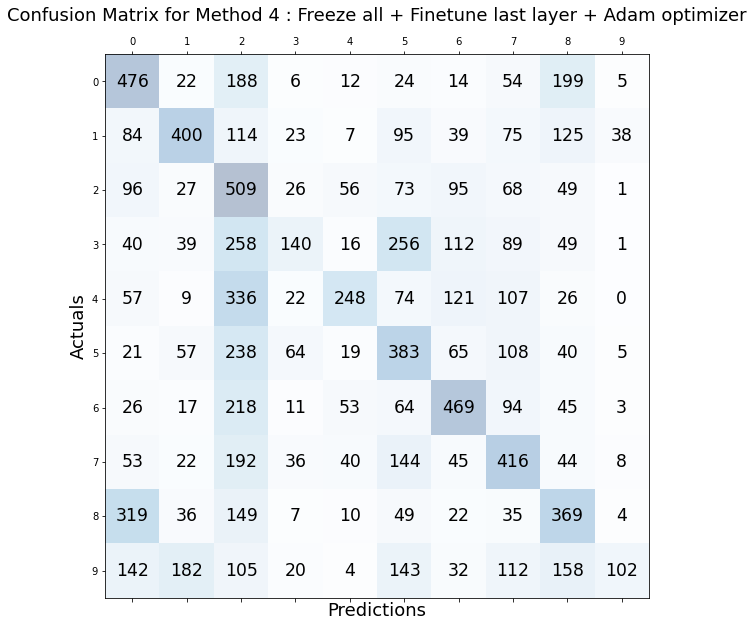

In [61]:
confusionMatrixWandb()
confusionMatrixSkLearn()